# Flight Delay Classification

Alon Hillel-Tuch | ah5647@nyu.edu

*Preface*

In order to make this project interesting, we are going to impose restrictions on what data we use to make a delay prediction. In specific, we will only use data a typical passenger would have access to. This is limited to: departure airport, arrival airport, airline, and date of flight (time,day,month,year). Our challenge will be to see how we can use this limited set of information to train a model to have an as high classification accuracy as possible.

In order to accelerate our ability to analyze the large dataset, I used a combination of a local desktop computer as well as Lambdalabs.com (TA Recommendation). This singular notebook was passed between different computer environments in order to complete all calculations (note that discrepancy between cell tags). Below are the specifications and estimated computational time:

- Cloud gpu_1x_a100_sxm4: 37.51 hours (used for pre-processing experimentation)
- Cloud gpu_8x_a100: 1.5 hours (used to import and sample initial rough data set)
- Local Computer: 38 hours (trial work and analysis)

Cloud gpu_1x_a100_sxm4: 30vCPUs, 200GiB RAM, 512GiB SSD, 40GB GPU

Cloud gpu_8x_a100: 124vCPUs, 1800GiB RAM, 6TiB SSD, 40GB GPU

Local Computer: 5900x (12C), 64GB RAM, 4TiB SSD, 8GB 3070 Ti

Total cost incured at Lambda Labs equals $54.56

**In order to decrease notebook file size some cell outputs have been cleared, this will make the cell appear as not having run or not having generated a verbose output. However, this was just to reduce file size so a copy can be stored on GitHub and uploaded to BrightSpace.**

## Problem Statement

Flying has become a common event for many of us. Which means we experience the consequences of a delayed, cancelled, or diverted flight. In recent times we have started to experience new friction points regarding travel:

- Flight schedules have become erratic during the pandemic
- Depending on destination, passengers must select flights with stop-overs
- We all have ‘assumptions’ on what is a good flight, be it airline, time of flight, destination, etc. However, can we express this as a strong predictive signal?
- Many of us have at times depended on air travel, developing an ability to classify a future delay is traveler advantageous


![alt text](flight_data.png "Flight Data")
*source: https://www.bts.gov/newsroom/air-travel-consumer-report-march-2022-and-1st-quarter-2022-numbers*

As we can see above, travel has slowly recovered from the recent pandemic, but there still are lingering logistical issues. 

**What we are going to try and do is see if we can accurately predict whether or not a flight is going to be delayed. Our goal is to provide a reasonable indicator of delay. While we can approach this as a regression or classification problem, we are going to take a classification approach and discuss further below.**

The datasource we are using is from the Bureau of Transportation Statistics. We are using their 'Airline On-Time Performance Data' database. The years we extract are 2019-2022 (https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFD&Yv0x=D). The data arrives as a csv. We used LambdaLab servers to preprocess the data and convert them into more manageable parquet files. 50% of the data size required 171G of main memory during processing. Preprocessing details are below. One-hot-encoding required most of the computational resources. 

The desired outcome is to use this classification model to provide passengers a reasonable ability to optimize their flight selection by trying to reduce delays. This means we are not only going to try and train an as effective (high recall) model as possible, but also identify relevant features and transform their relevance into flight booking recommendations.

###### Metrics: Precision vs Recall, and what else are we measuring?

![alt text](PrecisionRecall.png "Precision and Recall")
*source: https://en.wikipedia.org/wiki/F-score*

We need to review our target metrics within the context of the problem. Knowing that precision describes what proportion of positive delay identifications were actually correct, and recall describes what proportion of actual positive delays were identified correctly. We can recognize that a high recall is more important for our specific problem than high precision. While precision is important it is a lot worse incorrectly classive as negative and miss a positive (actually delayed) vs incorrectly classify as positive but is negative (actually not delayed). Essentially, being on a flight that is delayed is far worse then going on a flight expecting a delay and then not experiencing one. Therefore, besides our mean accuracy of prediction (classification) we will look at precision, recall, and F-1. The F-1 score helps us look at precision and recall as a single metric by incorporting the true positives, false postivies, and false negatives and providing us a measure of general test accuracy. For example, if both precision and recall are zero the F1 score is zero, if both are perfect the F1 score would be 1.0. Below is a great image outlining the different components.

We are not factoring in the computational cost (time/space/energy) taken. Some models require less memory than others, some are quicker and/or more efficient. We are purely focused on outcome scoring.

## Explaining the approach

###### Delay Definition & Regression vs Classification

When evaluating what we are predicting there is a decision to be made on looking at it as a regression problem and try and predict by 'how much' a plane may or may not be delayed (or arrive early). Or, we look at a binary classification of delay/not-delay. In this case, the Bureau of Transportation Statistics considers a delay to be >=15 minutes (https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFD&Yv0x=D).

I have decided to use this definition and approach the delay prediction as a classification problem. 

###### Data Source

We are using the datasets provided by The Bureau of Transportation Statistics (https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFD&Yv0x=D), and are looking at the last four years of data (2018-2021). The database only contains U.S. Domestic flights, we do not track inbound international our outbound international (from US centric perspective). The anticipation is that an expansion to international flights can happen with further research, but we would have to concat a lot of different databases managed by each country, so let's first see for this research project if we can even predict well.

I believe the time period we are looking at is going to have some interesting and potentially unique characteristics. Mainly the fact that this data-set time period covers the COVID-19 Pandemic peak, we included some flight data prior, the peak of the pandemic, and the post-peak (2022) slow return to normalcy (attempted return). This could mean that we may face difficulties in effectively training a model. Part of our challenge is to see if we can identify features that are universally significant! <u>We are also going to explore whether there is some concept drift (prediction shift) between the pre-pandemic data set isolated from 2020-2021 as well as inclusive of those years</u>. 

###### What are we looking to do? Methods and Decision Decisions

We are going to look at machine learning models that are well suited for classification. In order to prepare our training data for the models we are going to look to turn many of the features into binary expressions. For example if we have a feature 'Airline' and it consists of the set {delta,united,jetblue} we will take the unique possible string values (cardinality of 3) and transform them into independent features using one-hot encoding. Once we have pre-processing the data and prepared it for training we are going to run a quick analysis using scikit-learn model defaults. We will observe the general performance metrics, and make a selection on which models we are going to analyze for hyper parameter tuning. We are going to look in specific at recent years, 2018,2019, 2020, and 2021. This should provide an interesting mix of pre-pandemic and peak pandemic data. Flight data is substantial, just looking at US domestic flights, we approach 27M+ entries across all years. Therefore, for the initial version of this project, we will exclusively look at US domestic flights. Further methodology and design decisions below. 

### Initial Data Analysis

###### Importing for initial analysis

The initial datasets we are important are in CSV format and of substantial size (9.49GB diskspace). Importing them as a CSV resulted in memory issues, so one of the things we can do to speed it up retrieval and reduce storage cost is to convert the CSVs into Parquet files before importing them (https://parquet.apache.org/). We end up with 1.03GB of disk space usage moving to Parquet which is almost a factor 10 reduction!

In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import graphviz
from seaborn import heatmap

In [4]:
# databases
# importing our data from disk
df_2018 = pd.read_parquet('Combined_Flights_2018.parquet', engine='auto')
df_2019 = pd.read_parquet('Combined_Flights_2019.parquet', engine='auto')
df_2020 = pd.read_parquet('Combined_Flights_2020.parquet', engine='auto')
df_2021 = pd.read_parquet('Combined_Flights_2021.parquet', engine='auto')
# Note: we performed preliminary work converting the csv file into parquet. As part of this conversion we also already
# consolidated flight times (details on how below). To see how this is done, you can review on Kaggle
# numerous projects that include csv to parquet work (both in Python and C++ [go C++!]). We use a simple
# to parquet Python function in this notebook to store minor changes after the initial conversion. 

In [5]:
#Let's take a look
pd.set_option('display.max_columns', None)
df_2018.tail()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
637609,2018-09-11,Air Wisconsin Airlines Corp,SCE,IAD,False,False,1445,1433.0,0.0,-12.0,1515.0,0.0,35.0,61.0,42.0,133.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3839,ZW,20046,ZW,N437AW,3839,14711,1471105,34711,"State College, PA",PA,42,Pennsylvania,23,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,0.0,-1.0,1400-1459,4.0,1437.0,1512.0,3.0,1546,-31.0,0.0,-2.0,1500-1559,1,0.0
637610,2018-09-11,Air Wisconsin Airlines Corp,IAD,GSO,False,False,1235,1224.0,0.0,-11.0,1344.0,0.0,43.0,80.0,80.0,239.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3838,ZW,20046,ZW,N410AW,3838,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,11995,1199502,31995,"Greensboro/High Point, NC",NC,37,North Carolina,36,0.0,-1.0,1200-1259,30.0,1254.0,1337.0,7.0,1355,-11.0,0.0,-1.0,1300-1359,1,0.0
637611,2018-09-11,Air Wisconsin Airlines Corp,EVV,ORD,False,False,1030,1016.0,0.0,-14.0,1137.0,0.0,54.0,94.0,81.0,272.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3837,ZW,20046,ZW,N467AW,3837,11612,1161206,31612,"Evansville, IN",IN,18,Indiana,42,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,0.0,-1.0,1000-1059,20.0,1036.0,1130.0,7.0,1204,-27.0,0.0,-2.0,1200-1259,2,0.0
637612,2018-09-11,Air Wisconsin Airlines Corp,ORD,HPN,False,False,1410,1403.0,0.0,-7.0,1717.0,0.0,104.0,136.0,134.0,738.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3837,ZW,20046,ZW,N440AW,3837,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,12197,1219702,31703,"White Plains, NY",NY,36,New York,22,0.0,-1.0,1400-1459,25.0,1428.0,1712.0,5.0,1726,-9.0,0.0,-1.0,1700-1759,3,0.0
637613,2018-09-11,Air Wisconsin Airlines Corp,HPN,ORD,False,False,1800,1754.0,0.0,-6.0,1919.0,0.0,116.0,153.0,145.0,738.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3836,ZW,20046,ZW,N440AW,3836,12197,1219702,31703,"White Plains, NY",NY,36,New York,22,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,0.0,-1.0,1800-1859,14.0,1808.0,1904.0,15.0,1933,-14.0,0.0,-1.0,1900-1959,3,0.0


As we can see there is a lot of data we can use! However, remember our restrictions - we are not going to use information such as taxi time, wheels up, etc. We ideally want the model to allow us to look at a flight well in advance of it's actual date and see if we can predict a delay.

In [6]:
# Example Size of one of the years
print("Number of Samples: ", df_2019.shape[0])
print("Number of features: ", df_2019.shape[1])

Number of Samples:  8091684
Number of features:  61


I am considering a cancellation the same as an 'infinite delay', and it does not really help serve our purpose here. We are going to further define our conditions as predicting the delay of a flight that will eventually take-off, diversion will still be included, but we will remove all cancellation flights. 

In [7]:
df_2018 = df_2018.loc[df_2018['Cancelled'] != 1]
df_2019 = df_2019.loc[df_2019['Cancelled'] != 1]
df_2020 = df_2020.loc[df_2020['Cancelled'] != 1]
df_2021 = df_2021.loc[df_2021['Cancelled'] != 1]

# Analyzing one of the years after removing cancellations
print("Number of Samples: ", df_2019.shape[0])
print("Number of features: ", df_2019.shape[1])

Number of Samples:  7938055
Number of features:  61


Let's create one dataframe with all the flight data. This will be a big file, we are NOT YET going to delete the initial dataframes df_20xx to free up memory.

In [8]:
df = pd.concat([df_2018,df_2019,df_2020,df_2021])
df=df.dropna().reset_index(drop=True)

In [9]:
# How big is our dataset?
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])

Number of Samples:  24394594
Number of features:  61


This is massive! 24,394,594. This is after removal of cancellations and dropping NaN entries. We will need to sub-sample the data so that we can work on model training within a reasonable amount of time. We will also need to look at undersampling. Before doing so, let's look closer at the data to help inform our design decisions further. 

###### Taking a closer look at the data construct and start making observations for Feature Selection

<u>Delay Distribution</u>

Let's take some time to analyze the data and see what initial observations we can make. For example, let's see how significant the departure delay distribution is. 

In [10]:
df.DepDel15.value_counts() / len(df)

0.0    0.835137
1.0    0.164863
Name: DepDel15, dtype: float64

In [11]:
df.ArrDel15.value_counts() / len(df)

0.0    0.829828
1.0    0.170172
Name: ArrDel15, dtype: float64

Looking at the arrival delay (15+ minutes) we are looking at non delays being a factor 4.88 greater than delays. This informs our decision to perform undersampling and create a more balanced dataset. We still have many delay samples, so most likely we do not need to oversample the delay data but we may have to look at undersampling the not-delay data.

In [26]:
#setting up params for visualization
%matplotlib notebook
%config InlineBackend.figure_format = 'retina' #Force high resolution image to use in project presentation
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette("deep", desat=.6)
colors = sns.color_palette("deep")
sns.set_context(rc={"figure.figsize": (18, 5)})

In [27]:
#using a modified version from here (https://github.com/ibm-et/jupyter-samples/blob/master/airline/Exploration%20of%20Airline%20On-Time%20Performance.ipynb)
# We are going to group by State and store that data for visualization

by_origin_state = df.groupby('OriginState')
departure_delay_counts = by_origin_state.DepDel15.sum()

by_dest_state = df.groupby('DestState')
arrival_delay_counts = by_dest_state.ArrDel15.sum()

In [28]:
# Let's try and visualize (storing the dataframe)
delay_df = pd.DataFrame([departure_delay_counts, arrival_delay_counts]).T

<IPython.core.display.Javascript object>


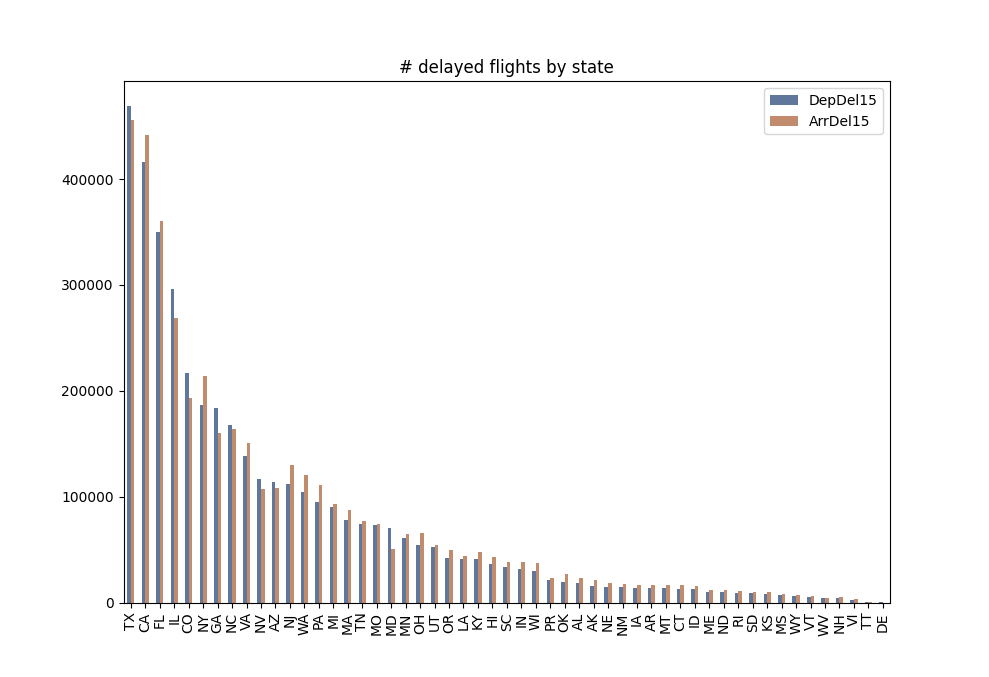

<AxesSubplot:title={'center':'# delayed flights by state'}>

In [25]:
%matplotlib notebook
delay_df.sort_values('DepDel15', ascending=False).plot(kind='bar', title='# delayed flights by state')

This chart is a bit missleading, we don't know the relationship between total flights in each state and delays. For example, Delaware has a trivially small number of delays, but what happens if on a percentage basis a delay occurs to 90% of flights? Let's take a look at the ratio of delay to total number of flights per state.

In [16]:
#modifying from (https://github.com/ibm-et/jupyter-samples/blob/master/airline/Exploration%20of%20Airline%20On-Time%20Performance.ipynb)
pct_departure_delay = departure_delay_counts / df.OriginState.value_counts()
pct_arrival_delay = arrival_delay_counts / df.DestState.value_counts()

<IPython.core.display.Javascript object>


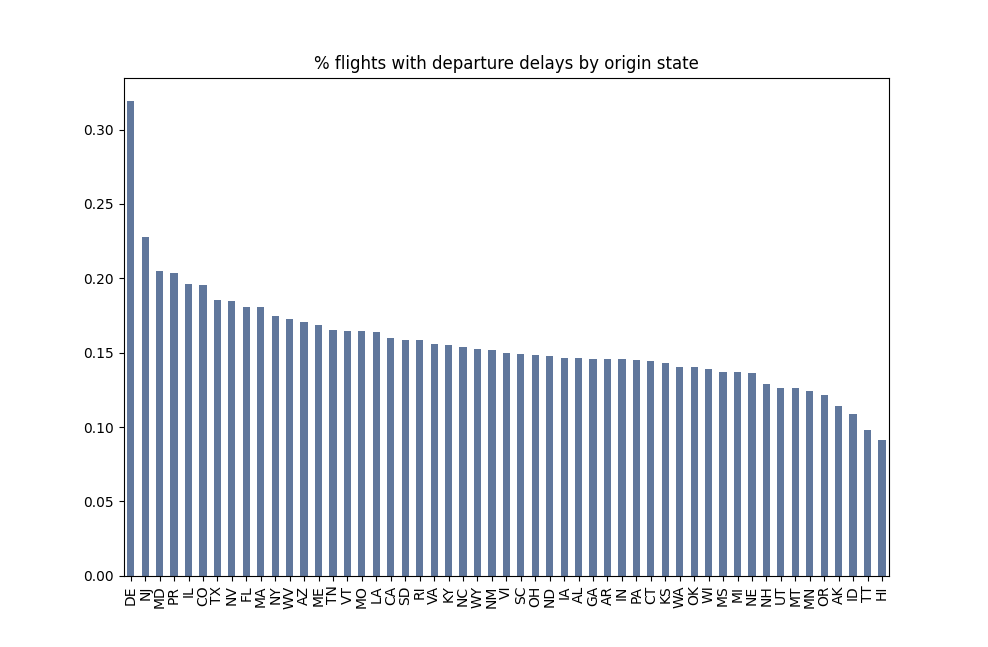

<AxesSubplot:title={'center':'% flights with departure delays by origin state'}>

In [29]:
pct_departure_delay.sort_values(ascending=False).plot(kind='bar', title='% flights with departure delays by origin state')

It is interesting to see that as a state, airports located in Delaware experience a high percentage of departure delays. While this is useful information for analysis, we have to keep in mind that knowing the departure delay is not a feature we can use as part of solving our problem statement. This is because we want any person looking to fly to look in advance and only provide their airline, flight date and dest/dept information. So let's look at our actual arrival delay statistics (+15min).

<IPython.core.display.Javascript object>


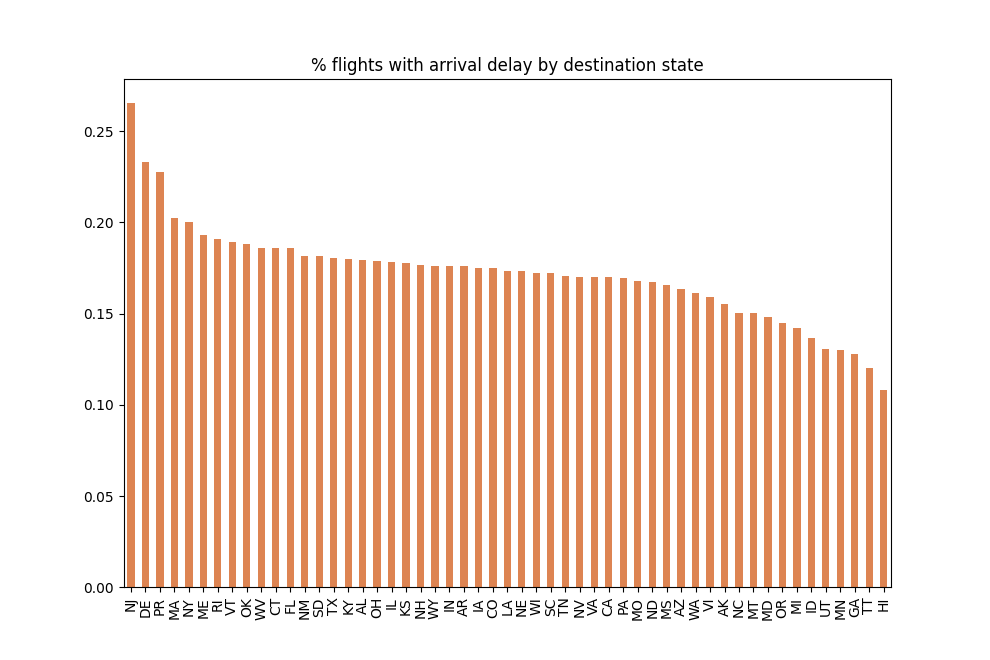

<AxesSubplot:title={'center':'% flights with arrival delay by destination state'}>

In [30]:
pct_arrival_delay.sort_values(ascending=False).plot(kind='bar', color=colors[1], title='% flights with arrival delay by destination state')

Aha, Delaware did have a higher ratio of delays!

A few things we can observe is that the departure delay and arrival delay (sum) appear correlated by state. Interesting is that specifically for arrivals, NJ performs poorly - the largest airport there is EWR Newark. Let's keep an eye on this to see if EWR as arrival airport becomes a significant feature when training our model.

While we cannot use the departure delay as a feature, it is good to know of the relationship. Expanding on this, we can see that certain states have significantly more delays than others, with population density being only one of many other factors. **This tells us that knowing the departure airport and arrival airport could be important features to consider.** By including both the departure and arrival airport we can also consider the relationship between specific airports, for example a DE to CA flight may have a higher delay probabiltiy than DE to NY.

<u>Airlines</u>

One reasonable assumption is that airlines function with different operating competencies, and may experience more or less delays depending on the company. Let's take a look.

We are going to use the field 'IATA_Code_Operating_Airline' cross-referenced with 'unique_carrier_code'.
The Department of Statistics indicates this field represents, "Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique. For analysis, use the Unique Carrier Code." We performed some pre-processing work on the original dataset and included a column called 'Airlines' which uniquely mapped the IATA codes to the Full Airline Name.


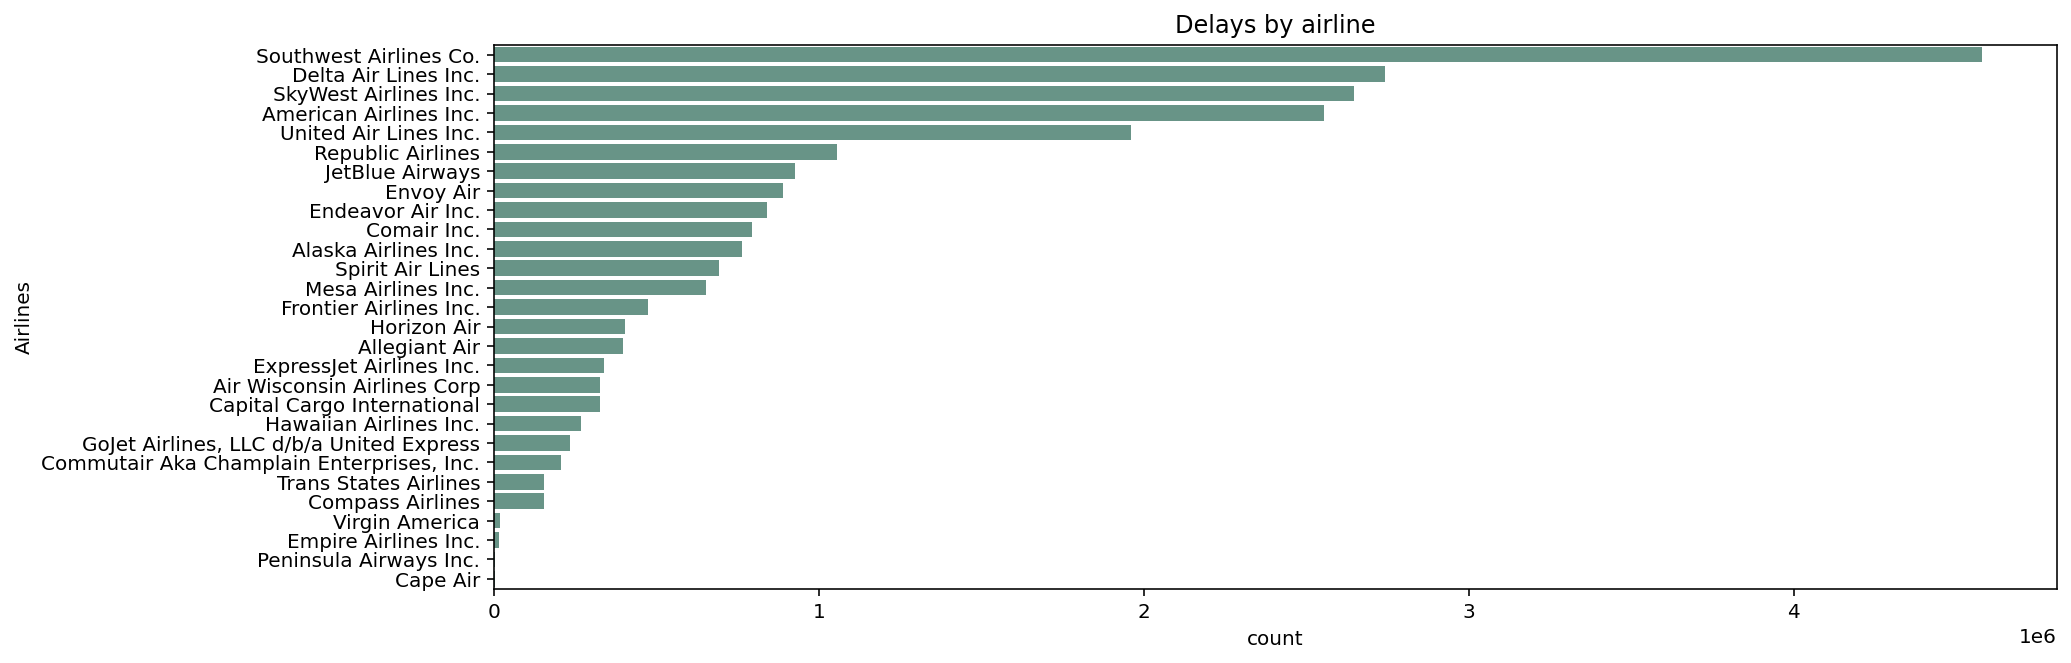

In [19]:
#Let's visualize delay by airline
import seaborn as sb
%matplotlib inline

# Useful settings modified from: https://www.kaggle.com/code/izumita/flight-delays-exploration-and-visualisation
%config InlineBackend.figure_format = 'retina' #Force high resolution image
color = '#619b8a'

plt.figure(figsize = [14, 5])
carriers_order = df.Airline.value_counts().index

sb.countplot(data = df, y = 'Airline',color = color, order = carriers_order);
plt.ylabel('Airlines')
plt.title('Delays by airline');

We can see that the airline used on a count basis can be a significantly contributing feature. However, as mentioned before, this is misleading. Let's look at the ratio, and represent is as a table outline delay percentage.

In [20]:
#let's look up the delay count for airlines and express the ratio between total flights and delays

import warnings
warnings.filterwarnings('ignore')

#num_airlines = 50

flight_counts = df.Airline.value_counts()[:]
carriers_order = flight_counts.index

column_names_ = ['Airline','Total Flights','Total Delays','Percentage']
airline_ratio = pd.DataFrame(columns=column_names_)


for i in range (flight_counts.shape[0]):
    total_delays = sum((df.Airline == carriers_order[i]) & (df.ArrDel15 ==1))
    #percentage = '{:0.1f}%'.format(100*total_delays/flight_counts[i])
    percentage = (100*total_delays/flight_counts[i])
    #new_row = pd.DataFrame([carriers_order[i],flight_counts[i],total_delays,percentage])
    airline_ratio = airline_ratio.append({'Airline':carriers_order[i],'Total Flights':flight_counts[i],'Total Delays':total_delays,'Percentage':percentage},ignore_index=True)
    #print(carriers_order[i],flight_counts[i],total_delays,percentage)

In [21]:
# This code allows us to easily change the sort key if needed
sort_by_ = 'Percentage'

airline_ratio = airline_ratio.sort_values(by=[sort_by_], ascending=False,ignore_index=True)
airline_ratio

,Airline,Total Flights,Total Delays,Percentage
0,Peninsula Airways Inc.,2291,854,37.276299
1,"Commutair Aka Champlain Enterprises, Inc.",205514,56816,27.645805
2,Trans States Airlines,154379,39580,25.638202
3,JetBlue Airways,924933,224908,24.316140
4,Frontier Airlines Inc.,472033,108035,22.887171
5,Allegiant Air,395131,88916,22.502917
6,ExpressJet Airlines Inc.,338236,72898,21.552407
7,Virgin America,17153,3440,20.054801
8,Mesa Airlines Inc.,652709,125014,19.153099
9,"GoJet Airlines, LLC d/b/a United Express",234298,44506,18.995467


We can validate our initial assumption that the airline used has a direct effect on the probability of a delay. Certain airlines such as Delta have a 12.27% percentage of delays, while Peninsula Airways has a 37.28% percentage of delays. We should incorporate 'airline' as a feature.

<u>Date (Seasonality</u>

One other assumption we have is that there may be seasonality to flying. That is, perhaps there is a higher demand around common flight months. An example could be the start of summer session for schools. Children having holiday could imply an increased demand by families to travel, and this may increase the usage of the domestic US flying network. Let's take a look at time related data.

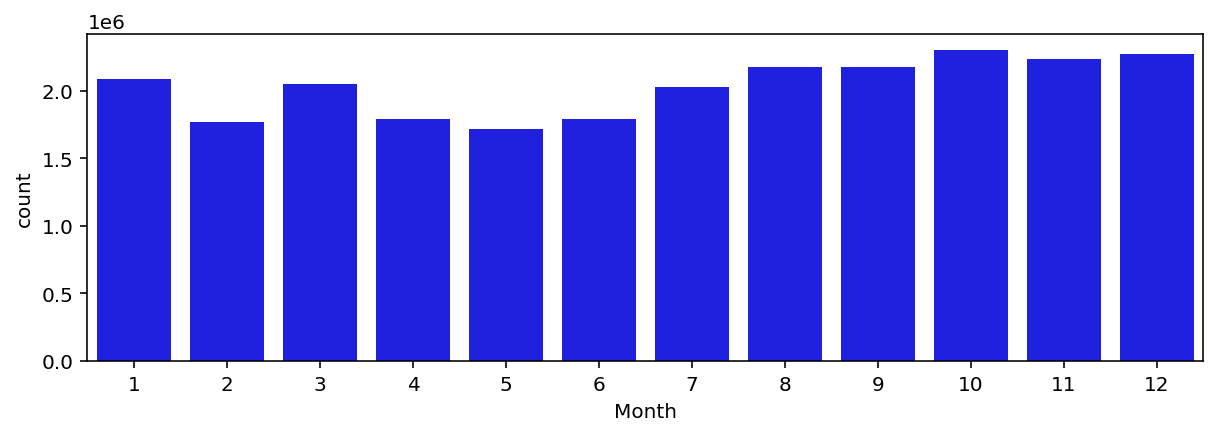

In [22]:
#Number of flights by month
plt.figure(figsize = [10, 3])
sb.countplot(data=df, x='Month', color='blue');

plt.figure(figsize = [10, 3])
sb.countplot(data=df, x='DayofMonth', color='green');

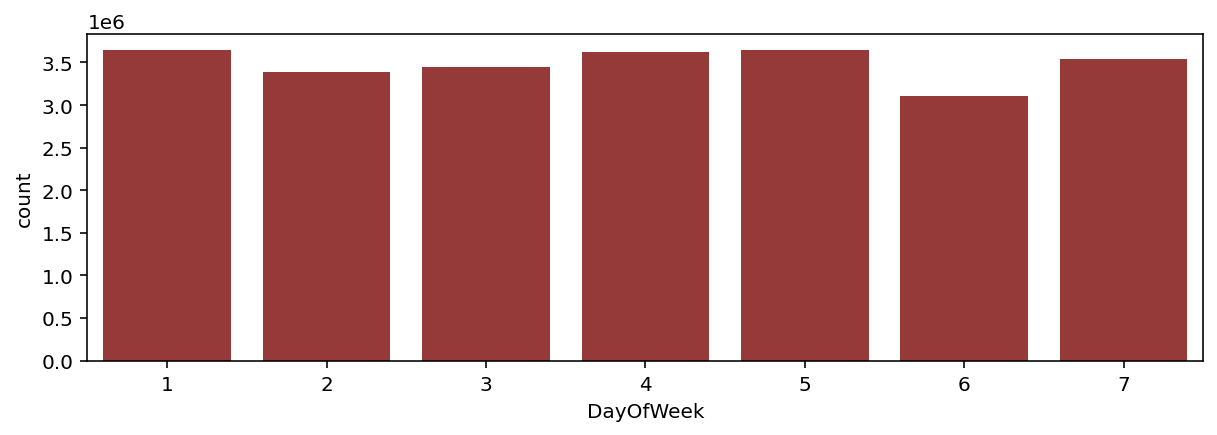

In [23]:
#Number of flights day of the week
#Day1 = Monday
#Day7 = Sunday
days_in_week = [1, 2, 3, 4, 5, 6, 7]
plt.figure(figsize = [10, 3])
sb.countplot(data=df, x='DayOfWeek', color='brown', order=days_in_week);

We are not visually observing a significant difference between travel activity over various months, except that the "busy season" appears to be from July to December. This does coincide with popular holiday and school schedules. As expected, Saturday (day 6) is the least active flight day, that is most likely due it being neither popular for business nor leasure travel.

## Initial Approach

###### Initial Feature Selection Discussion

With the information we uncovered above.We can start thinking about what features to extract and select for model training. 

We are going to use a binary entry that notates an Arrival Delay > 15 minutes. We will call it ArrDel15. 

We are also going to look at:
- Airline
- Destination Airport
- Origin Airport
- Month of Flight
- Day of Week (of flight)
- Departure Time



In order to have the departure time be useful from a categorical perspective we are going to look at creating time-blocks of one hour each. For example if a flight is at 09:30, it's string value for time would be 09:00-09:59. A flight departing at 21:43 would have as a string value for time 21:00-21:59. We therefore will have 24 unique values for departure time. This will result after one-hot encoding into 24 features related to time. 

Since we are looking to create a classification model we can think about different ways to approach pre-processing the data. As mentioned before, since most of our data are string values (i.e. "Delta" from "JFK" to "LAX" at "09:00-09:59" on 1 (January) 4 (Thursday)) it may make sense to perform one-hot encoding and transform the string variable features into feature categories. While my suspicion is that a Decision Tree model would be best suited, we are going to trial multiple models, as such, we need to keep standardization in mind, however with all the above being categorical and translated into a dataframe with exclusively binary 1/0 entries, we are going to be ok. We are going to have a very large number of features, this can be resource intensive, let's see if we face any roadblocks that can require down-the-road solutions such as Principal Component Analysis or other grouping/simplifcation strategies. 

###### Selecting our Features

In [4]:
#selecting our features
df_2018_new = df_2018[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk']]
df_2019_new  = df_2019[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk']]
df_2020_new  = df_2020[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk']]
df_2021_new  = df_2021[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk']]

In [5]:
#Let's take a look at one of the dataframes
df_2021_new.head()

,ArrDel15,Airline,Dest,Origin,Month,DayOfWeek,DepTimeBlk
0,0.0,SkyWest Airlines Inc.,PHX,SGU,3,3,0700-0759
1,0.0,SkyWest Airlines Inc.,SGU,PHX,3,3,0900-0959
2,0.0,SkyWest Airlines Inc.,ORD,MHT,3,3,1300-1359
3,0.0,SkyWest Airlines Inc.,TRI,DFW,3,3,1600-1659
4,0.0,SkyWest Airlines Inc.,BFL,PHX,3,3,1800-1859


In [6]:
# creating one single dataframe of all flights
df = pd.concat([df_2018_new,df_2019_new,df_2020_new,df_2021_new])
df=df.dropna().reset_index(drop=True)
del [[df_2018_new,df_2019_new,df_2020_new,df_2021_new]] #free up memory

#store our individual df's as parquet files as well to retrieve latter (memory)

df_2018.to_parquet('df_2018_orig.parquet')
df_2019.to_parquet('df_2019_orig.parquet')
df_2020.to_parquet('df_2020_orig.parquet')
df_2021.to_parquet('df_2021_orig.parquet')
del [[df_2018,df_2019,df_2020,df_2021]] #free up memory


#let's take a peek
df.head()

,ArrDel15,Airline,Dest,Origin,Month,DayOfWeek,DepTimeBlk
0,0.0,Endeavor Air Inc.,ATL,ABY,1,2,1200-1259
1,0.0,Endeavor Air Inc.,ATL,ABY,1,3,1200-1259
2,0.0,Endeavor Air Inc.,ATL,ABY,1,4,1200-1259
3,0.0,Endeavor Air Inc.,ATL,ABY,1,5,1200-1259
4,0.0,Endeavor Air Inc.,ATL,ABY,1,6,1400-1459


###### Pre-Processing

In [7]:
# Analyzing data - See how many entries we have
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])

Number of Samples:  24402683
Number of features:  7


In [8]:
feature_names_orig = df.columns[1:]
feature_names_orig

Index(['Airline', 'Dest', 'Origin', 'Month', 'DayOfWeek', 'DepTimeBlk'], dtype='object')

<u>One-Hot Encoding</u>

We need to encode our features properly. For example, Month is an integer value of 1-12, but it should not be seen as 12 being 'larger' than 11, each is a category. So we perform one-hot encoding to encode each value in the feature to a feature category. 

In [9]:
df = pd.get_dummies(df, columns=['Month'], prefix="Month")
df.head()

,ArrDel15,Airline,Dest,Origin,DayOfWeek,DepTimeBlk,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,0.0,Endeavor Air Inc.,ATL,ABY,2,1200-1259,1,0,0,0,0,0,0,0,0,0,0,0
1,0.0,Endeavor Air Inc.,ATL,ABY,3,1200-1259,1,0,0,0,0,0,0,0,0,0,0,0
2,0.0,Endeavor Air Inc.,ATL,ABY,4,1200-1259,1,0,0,0,0,0,0,0,0,0,0,0
3,0.0,Endeavor Air Inc.,ATL,ABY,5,1200-1259,1,0,0,0,0,0,0,0,0,0,0,0
4,0.0,Endeavor Air Inc.,ATL,ABY,6,1400-1459,1,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df = pd.get_dummies(df, columns=['DayOfWeek'], prefix="DayOfWeek")
df.head()

,ArrDel15,Airline,Dest,Origin,DepTimeBlk,Month_1,Month_2,Month_3,Month_4,Month_5,...,Month_10,Month_11,Month_12,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0.0,Endeavor Air Inc.,ATL,ABY,1200-1259,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,Endeavor Air Inc.,ATL,ABY,1200-1259,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,Endeavor Air Inc.,ATL,ABY,1200-1259,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,Endeavor Air Inc.,ATL,ABY,1200-1259,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,Endeavor Air Inc.,ATL,ABY,1400-1459,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
df = pd.get_dummies(df, columns=['DepTimeBlk'], prefix="DepTimeBlk")
df.head()

,ArrDel15,Airline,Dest,Origin,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepTimeBlk_1400-1459,DepTimeBlk_1500-1559,DepTimeBlk_1600-1659,DepTimeBlk_1700-1759,DepTimeBlk_1800-1859,DepTimeBlk_1900-1959,DepTimeBlk_2000-2059,DepTimeBlk_2100-2159,DepTimeBlk_2200-2259,DepTimeBlk_2300-2359
0,0.0,Endeavor Air Inc.,ATL,ABY,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,Endeavor Air Inc.,ATL,ABY,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,Endeavor Air Inc.,ATL,ABY,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,Endeavor Air Inc.,ATL,ABY,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,Endeavor Air Inc.,ATL,ABY,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [12]:
df = pd.get_dummies(df, columns=['Airline'], prefix="Airline")
df.head()

,ArrDel15,Dest,Origin,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Airline_JetBlue Airways,Airline_Mesa Airlines Inc.,Airline_Peninsula Airways Inc.,Airline_Republic Airlines,Airline_SkyWest Airlines Inc.,Airline_Southwest Airlines Co.,Airline_Spirit Air Lines,Airline_Trans States Airlines,Airline_United Air Lines Inc.,Airline_Virgin America
0,0.0,ATL,ABY,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,ATL,ABY,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,ATL,ABY,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,ATL,ABY,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,ATL,ABY,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df = pd.get_dummies(df, columns=['Origin'], prefix="Origin")
df.head()

,ArrDel15,Dest,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,...,Origin_VLD,Origin_VPS,Origin_WRG,Origin_WYS,Origin_XNA,Origin_XWA,Origin_YAK,Origin_YKM,Origin_YNG,Origin_YUM
0,0.0,ATL,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,ATL,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,ATL,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,ATL,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,ATL,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df = pd.get_dummies(df, columns=['Dest'], prefix="Dest")
df.head()

,ArrDel15,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_XWA,Dest_YAK,Dest_YKM,Dest_YNG,Dest_YUM
0,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Let's take a look at it all together (it's going to be big!)
pd.set_option('display.max_columns', None)
df.head()

,ArrDel15,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,DepTimeBlk_0001-0559,DepTimeBlk_0600-0659,DepTimeBlk_0700-0759,DepTimeBlk_0800-0859,DepTimeBlk_0900-0959,DepTimeBlk_1000-1059,DepTimeBlk_1100-1159,DepTimeBlk_1200-1259,DepTimeBlk_1300-1359,DepTimeBlk_1400-1459,DepTimeBlk_1500-1559,DepTimeBlk_1600-1659,DepTimeBlk_1700-1759,DepTimeBlk_1800-1859,DepTimeBlk_1900-1959,DepTimeBlk_2000-2059,DepTimeBlk_2100-2159,DepTimeBlk_2200-2259,DepTimeBlk_2300-2359,Airline_Air Wisconsin Airlines Corp,Airline_Alaska Airlines Inc.,Airline_Allegiant Air,Airline_American Airlines Inc.,Airline_Cape Air,Airline_Capital Cargo International,Airline_Comair Inc.,"Airline_Commutair Aka Champlain Enterprises, Inc.",Airline_Compass Airlines,Airline_Delta Air Lines Inc.,Airline_Empire Airlines Inc.,Airline_Endeavor Air Inc.,Airline_Envoy Air,Airline_ExpressJet Airlines Inc.,Airline_Frontier Airlines Inc.,"Airline_GoJet Airlines, LLC d/b/a United Express",Airline_Hawaiian Airlines Inc.,Airline_Horizon Air,Airline_JetBlue Airways,Airline_Mesa Airlines Inc.,Airline_Peninsula Airways Inc.,Airline_Republic Airlines,Airline_SkyWest Airlines Inc.,Airline_Southwest Airlines Co.,Airline_Spirit Air Lines,Airline_Trans States Airlines,Airline_United Air Lines Inc.,Airline_Virgin America,Origin_ABE,Origin_ABI,Origin_ABQ,Origin_ABR,Origin_ABY,Origin_ACK,Origin_ACT,Origin_ACV,Origin_ACY,Origin_ADK,Origin_ADQ,Origin_AEX,Origin_AGS,Origin_AKN,Origin_ALB,Origin_ALO,Origin_ALS,Origin_ALW,Origin_AMA,Origin_ANC,Origin_APN,Origin_ART,Origin_ASE,Origin_ATL,Origin_ATW,Origin_ATY,Origin_AUS,Origin_AVL,Origin_AVP,Origin_AZA,Origin_AZO,Origin_BDL,Origin_BET,Origin_BFF,Origin_BFL,Origin_BFM,Origin_BGM,Origin_BGR,Origin_BHM,Origin_BIH,Origin_BIL,Origin_BIS,Origin_BJI,Origin_BKG,Origin_BLI,Origin_BLV,Origin_BMI,Origin_BNA,Origin_BOI,Origin_BOS,Origin_BPT,Origin_BQK,Origin_BQN,Origin_BRD,Origin_BRO,Origin_BRW,Origin_BTM,Origin_BTR,Origin_BTV,Origin_BUF,Origin_BUR,Origin_BWI,Origin_BZN,Origin_CAE,Origin_CAK,Origin_CDB,Origin_CDC,Origin_CDV,Origin_CGI,Origin_CHA,Origin_CHO,Origin_CHS,Origin_CID,Origin_CIU,Origin_CKB,Origin_CLE,Origin_CLL,Origin_CLT,Origin_CMH,Origin_CMI,Origin_CMX,Origin_CNY,Origin_COD,Origin_COS,Origin_COU,Origin_CPR,Origin_CRP,Origin_CRW,Origin_CSG,Origin_CVG,Origin_CWA,Origin_CYS,Origin_DAB,Origin_DAL,Origin_DAY,Origin_DBQ,Origin_DCA,Origin_DDC,Origin_DEC,Origin_DEN,Origin_DFW,Origin_DHN,Origin_DIK,Origin_DLG,Origin_DLH,Origin_DRO,Origin_DRT,Origin_DSM,Origin_DTW,Origin_DUT,Origin_DVL,Origin_EAR,Origin_EAT,Origin_EAU,Origin_ECP,Origin_EGE,Origin_EKO,Origin_ELM,Origin_ELP,Origin_ERI,Origin_ESC,Origin_EUG,Origin_EVV,Origin_EWN,Origin_EWR,Origin_EYW,Origin_FAI,Origin_FAR,Origin_FAT,Origin_FAY,Origin_FCA,Origin_FLG,Origin_FLL,Origin_FLO,Origin_FNT,Origin_FOD,Origin_FSD,Origin_FSM,Origin_FWA,Origin_GCC,Origin_GCK,Origin_GEG,Origin_GFK,Origin_GGG,Origin_GJT,Origin_GNV,Origin_GPT,Origin_GRB,Origin_GRI,Origin_GRK,Origin_GRR,Origin_GSO,Origin_GSP,Origin_GST,Origin_GTF,Origin_GTR,Origin_GUC,Origin_GUM,Origin_HDN,Origin_HGR,Origin_HHH,Origin_HIB,Origin_HLN,Origin_HNL,Origin_HOB,Origin_HOU,Origin_HPN,Origin_HRL,Origin_HSV,Origin_HTS,Origin_HVN,Origin_HYA,Origin_HYS,Origin_IAD,Origin_IAG,Origin_IAH,Origin_ICT,Origin_IDA,Origin_ILG,Origin_ILM,Origin_IMT,Origin_IND,Origin_INL,Origin_IPT,Origin_ISN,Origin_ISP,Origin_ITH,Origin_ITO,Origin_JAC,Origin_JAN,Origin_JAX,Origin_JFK,Origin_JHM,Origin_JLN,Origin_JMS,Origin_JNU,Origin_JST,Origin_KOA,Origin_KTN,Origin_LAN,Origin_LAR,Origin_LAS,Origin_LAW,Origin_LAX,Origin_LBB,Origin_LBE,Origin_LBF,Origin_LBL,Origin_LCH,Origin_LCK,Origin_LEX,Origin_LFT,Origin_LGA,Origin_LGB,Origin_LIH,Origin_LIT,Origin_LNK,Origin_LNY,Origin_LRD,Origin_LSE,Origin_LWB,Origin_LWS,Origin_LYH,Origin_MAF,Origin_MBS,Origin_MCI,Origin_MCO,Origin_MCW,Origin_MDT,Origin_MDW,Origin_MEI,Origin_MEM,Origin_MFE,Origin_MFR,Origin_MGM,Origin_MHK

In [16]:
# Analyzing data - Let's see our feature 'bloat'
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])

Number of Samples:  24402683
Number of features:  843


A considerable increase in the number of features used! The number of samples is substantial even after initial filtering. So now that we have formatted our dataset, let's store it as a parquet file so we can easily call it. For more information on Parquet (https://parquet.apache.org/). <u>We are also going to extract only a fraction of the total data to make it more manageable for training and experimentation purposes.</u>

In [ ]:
#taking a fraction of our data and storing
#In this case .1 implies we are going to sub sample to 10%.
#That is, from an theoretical 100 samples we will randomly select 10.
df= df.sample(frac=.1).reset_index(drop=True)
df.to_parquet('df_initial_frac_10.parquet')

###### Initial Training Assessment 

We are going to be working within scikit-learn. While we are going to look at the basic decision tree model we are also going to look at variations (such as random forest) as well as boosting (ada,gradient,LG,XG). We will also attempt Logistic Regression classificaiton, stochastic-gradient decent classifier, K-Neighbors, Gaussian Process, Naive Bayes, and as suggested MLP neural network. MLP and Gradient Boosting in specific, were recommended additional models to trial.

While I was interested in performing an SVM model analysis (with something such as an rbf kernel), the datasets is so large, that in order to build the appropriate number of dimensions from the non-linear data we would have needed a significant amount of computational resources. In an experiment I licensed time from Lambda Labs (www.lambdalabs.com) which included 8x Nvidia A100 chips resulting in 1.8TB of ram and 24vCPUs. Unfortunately, even though this covered the main memory requirements, due to scikit-learns limited support of multi-threading or GPU assisted computing, the time taken for analysis would have been unreasonable. Do note that CatBoost has recently included GPU support, and we make full use of it (using a 3070ti w/ 8GB memory). 

In [2]:
# Imports
# There are quite a few imports as we are selecting several different classification models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import graphviz
from seaborn import heatmap

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

#classification models
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import CategoricalNB

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RepeatedStratifiedKFold

#in case we do any regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [26]:
#We are re-loading the file - note that this is here because this is an active Notebook allowing me to easily swap out datasets at specific points
df = pd.read_parquet('df_initial_frac_10.parquet', engine='auto')

#for storing a sample (we comment un-comment as appropriate)
#df= df.sample(frac=.1).reset_index(drop=True)

In [27]:
#insight into our memory usage and data-set size/features
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2440268 entries, 0 to 2440267
Columns: 843 entries, ArrDel15 to Dest_YUM
dtypes: float64(1), uint8(842)
memory usage: 1.9 GB


In [28]:
#Removing any NA
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])

df=df.dropna().reset_index(drop=True)

# Analyzing data change
print("Number of Samples after NaN Drop: ", df.shape[0])
print("Number of features after NaN Drop:  ", df.shape[1])

# Note, we already processed before (so would be the same), but while experimenting we were running certain other datasets 
# this is useful to keep in.

Number of Samples:  2440268
Number of features:  843
Number of Samples after NaN Drop:  2440268
Number of features after NaN Drop:   843


In [29]:
#setting our y value to be the ArrDel15 column
y = df.values[:,0]

In [30]:
#importing all our features
X = df.values[:, 1:]

In [31]:
#storing for future graphing purposes
feature_names_ = df.columns[1:]
class_names_ = df.ArrDel15.unique()
feature_names_

Index(['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10',
       ...
       'Dest_VLD', 'Dest_VPS', 'Dest_WRG', 'Dest_WYS', 'Dest_XNA', 'Dest_XWA',
       'Dest_YAK', 'Dest_YKM', 'Dest_YNG', 'Dest_YUM'],
      dtype='object', length=842)

###### Under-Sampling

As we noticed earlier during our analysis there is quite an imbalance 1:4.88. We need to undersampling and bring balance to the dataset. 

In [32]:
#from https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 

print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 2025093, 1.0: 415175})
Resampled dataset shape Counter({0.0: 415175, 1.0: 415175})


###### Creating Training, Test, and Validation Sets

We're splitting our data into three sets, while a train/test set alone is sufficient, our dataset is so large it is interesting to take a 2nd validation set alongside test to see if we notice any discrepancies (there shouldn't be).

In [33]:
test_size_ = 0.2
random_state_ = 42


X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=test_size_,random_state=random_state_)

#now split the 80 training set (20 to val) making it 60,20,20
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=random_state_)

#clear memory
X = 0
y = 0

###### Running Models & Comparing Different Techniques

We wrote a function that will run each model specified and store the results in an array for analysis. **Right now we are using all models with default parameter and will tune parameters after initial observation**.

In [3]:
#model selection list (this is for the function we created that runs multiple models)
#Gaussian required 1.8TB of ram
#SVM requires significant computational time, we tried to run this initially but it occupied several days of computation.
#As such, we are dropping SVM and it's kernel options from our model selections.
models_ = [LogisticRegression(max_iter=5000), SGDClassifier(), KNeighborsClassifier(),  CategoricalNB(), DecisionTreeClassifier(),AdaBoostClassifier(),CatBoostClassifier(task_type="GPU"),LGBMClassifier(),XGBClassifier(),GradientBoostingClassifier(),RandomForestClassifier(),MLPClassifier()]

In [4]:
#standard list of models we are using
#models_ = [DecisionTreeClassifier(),AdaBoostClassifier(),CatBoostClassifier(),LGBMClassifier(),XGBClassifier(),GradientBoostingClassifier(),RandomForestClassifier(),MLPClassifier()]

# regression: LinearRegression(),Ridge(),Lasso(),ElasticNet(),DecisionTreeRegressor()
# The functions below will run each model from our list using default parameters (unless otherwise specified)
# This a modified version of the functions built for the real estate analysis assignment.

def set_array(model_def):
    
    global models_
    
    if model_def == True:
        models_ = [DecisionTreeClassifier(),AdaBoostClassifier(),CatBoostClassifier(),LGBMClassifier(),XGBClassifier(),GradientBoostingClassifier(),RandomForestClassifier(),MLPClassifier()]
        
    global acc_train_arr
    acc_train_arr = []
    global test_precision_arr
    test_precision_arr = []
    
    global acc_test_arr
    acc_test_arr = []
    global test_recall_arr
    test_recall_arr = []
 
    
    global acc_val_arr
    acc_val_arr = []
    global test_fscore_arr
    test_fscore_arr = []
       
    global features_
    features_ = ['Model','Acc_train','Acc_validation','Acc_test','Precision Test','Recall Test','F1 Test']
    
    global labels_
    #labels_ = ['DecisionTree','AdaBoost','CatBoost','LGBM','XGB','GradientBoost','Random Forest','MLP']
    #labels_ = ['Logistic Regression','SGD Classifier','K-Neighbors','Categorical Naive Bayes','DecisionTree','AdaBoost','CatBoost','LGBM','XGB','GradientBoost','Random Forest','MLP']
    labels_ = ['Logistic Regression','SGD Classifier','K-Neighbors','DecisionTree','AdaBoost','CatBoost','LGBM','XGB','GradientBoost','Random Forest','MLP']
    
    
def append_data(model,plot,i):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_hat = model.predict(X_test)
    y_pred_val = model.predict(X_val)
    
    acc_train_arr.append(model.score(X_train, y_train))
    acc_test_arr.append(model.score(X_test, y_test))
    acc_val_arr.append(model.score(X_val, y_val))
    
    [precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='macro')
    #precision
    test_precision_arr.append(precision)
    #recall
    test_recall_arr.append(recall)
    #F1
    test_fscore_arr.append(fscore)
    
    if plot==True:
        plot_gd_prd(labels_[i],y_test,y_hat)
        
def run_model(plot):
    for i in range(len(labels_)):
        print("Running model:",labels_[i],"...")
        model = models_[i]
        model.fit(X_train, y_train)
        if plot == True:
            append_data(model,True,i)
        else:
            append_data(model,False,i)
    comb_tuples = list(zip(labels_,acc_train_arr,acc_test_arr,acc_val_arr,test_precision_arr,test_recall_arr,test_fscore_arr))
    df_comb = pd.DataFrame(comb_tuples)
    df_comb.columns = features_
    return df_comb

    
def run_model_set(plot,model_def):
    acc_train_arr = []
    acc_test_arr = []
    acc_val_arr = []
    
    test_precision_arr = []
    test_recall_arr = []
    test_fscore_arr = []
    
    models_ = []
    features_ = []
    labels_ = []

    set_array(model_def)
    
    return run_model(plot)

#plotting function if we decide to use
def plot_gd_prd(model, y_test,y_hat):

    fig, ax = plt.subplots()
    ax.scatter(y_test, y_hat)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=1)
    ax.set_xlabel('Actual (Ground Truth)')
    ax.set_ylabel('Predicted')
    title_ = "Ground Truth vs Predicted: " + model
    ax.set_title(title_)


In [ ]:
#Run multiple models with default params to see what we get
df_comb = run_model_set(False,False)

In [30]:
#our results (this was split into different cells to manage the computational work better)
df_comb

,Model,Acc_train,Acc_validation,Acc_test,Precision Test,Recall Test,F1 Test
0,Logistic Regression,0.603517,0.600337,0.601969,0.600455,0.600323,0.600200
1,SGD Classifier,0.576219,0.576215,0.575239,0.577481,0.576162,0.574382
2,K-Neighbors,0.724757,0.567387,0.567080,0.567417,0.567378,0.567320
3,Categorical Naive Bayes,0.597437,0.595267,0.596622,0.595423,0.595250,0.595077
4,DecisionTree,0.973752,0.555392,0.556229,0.555416,0.555399,0.555362
5,AdaBoost,0.597005,0.596447,0.597308,0.596638,0.596429,0.596220
6,CatBoost,0.632536,0.613753,0.615704,0.613755,0.613751,0.613749
7,LGBM,0.612145,0.608635,0.610345,0.608648,0.608639,0.608628
8,XGB,0.622691,0.608882,0.610875,0.608921,0.608873,0.608835
9,GradientBoost,0.597425,0.595598,0.596194,0.596537,0.595558,0.594554


This result appears quite poor. Note that initially we were obtaining a 0.52 F1 for catboost on average for most models. It was improved to the 0.61 mark on average after removing the cancellations and diversions. Our results are only marginally better than randomly quessing. 

We notice that when it comes to recall on our test set a simple logistic regression model performs quite well, however CatBoost and XGB both have the highest recall test values with CatBoost having the highest accuracy as well, leading to a F1 score of 0.613749 which is 1% higher (by pts) than any other model (a very small number).

Is that simply the case when using our feature selection restrictions, or can we tune further? Let's see what else we can do!

## Comparing Different Techniques Further & Tuning Analysis

In order to be as specific as possible in selecting our hyper-parameters we are actually going to run a GridSearchCV with different settings to observe what would result in the best possible estimator and score and which hyper parameters led to that result. I want to point out we are looking here for an optimization against the training data exclusively. This does mean, that we **could experience over or under fitting**. Once we have what appears to be optimal parameters for the training set we will see how they translate to prediction accuracy in the test set as well as precision and recall specifics.   

We are going to review Random Forest as a stand alone, and then out out of the boosting based models we will select CatBoost, which with default parameters performed best from an accuracy perspective and F1 Score. Considering our data has been formatted as predominantly categorical features during pre-processing, this is a bit anticipated. 

<u>Random Forest</u>

In [23]:
import warnings
warnings.filterwarnings("ignore") #for fit failures that may occur

#modified from article: https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-classification
#oblivious_tree_options.cpp:125: Maximum tree depth is 16
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#see scikit-learn documentation on randomforest classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

GS_estimator = RandomForestClassifier()
#n_estimators int, default=100
#criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
#max_depth int, default=None
#min_samples_leaf int or float, default=1

parameters = {'n_estimators':[10,80,100,200,400,600,800,1600,2000],'criterion':['gini','entropy','log_loss'],'max_depth':['None',8,12,14,16,20],'min_samples_leaf':[1,2,4]}

Grid_model = GridSearchCV(estimator=GS_estimator, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_model.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': ['None', 8, 12, 14, 16, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [10, 80, 100, 200, 400, 600, 800, 1600,
                                          2000]})

In [24]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_model.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_model.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_model.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=800)

 The best score across ALL searched params:
 0.5942527348777349

 The best parameters across ALL searched params:
 {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'n_estimators': 800}


What we did above is look at different combinations of hyper parameters to see if there is an optimal setting we can approach. Do note that in order to make this task 'approachable' by our computer system we subsampled the .1 set by another .1. Which is effectively 1% of our total dataset. Later on we will try and apply our solution to as close as the whole dataset as possible. Below we run our random forrest classifier model with the more 'optimal' settings.

In [25]:
criterion_='gini'
max_depth_=20
min_samples_leaf_=4
n_estimators_=800


model =  RandomForestClassifier(criterion=criterion_, max_depth=max_depth_, min_samples_leaf=min_samples_leaf_,n_estimators=n_estimators_)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')

In [26]:
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.6424951737451737
Mean Accuracy Test 0.5936538577547203
Mean Accuracy Validate 0.5996863123604995
Precision Test 0.5936538577547203
Recall Test 0.5936538577547203
fscore Test 0.5936538577547203


As you can see we are approaching slightly better results, but nothing spectacular. We are seeing a ~10.2% improvement over the default model parameters. Let's take a look at our best (F1) default performer, catboost below.

<u>CatBoost</u>

In [ ]:
#note: previous versions were run with 1,000 and 1,400 iterations as well as a few additional parameters. 
#This is a stripped down version to provide a very high level review for tuning. I noticed, that while there were differences
#between the iterations, it merely was directional in terms of performance, that is the relationships between parameters
#held true and consistent regardless of iterations, but additional iterations appears to increase (mostly) F1 and
#classification accuracy. 

import warnings
warnings.filterwarnings("ignore") #for fit failures that may occur

#modified from article: https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-classification
#oblivious_tree_options.cpp:125: Maximum tree depth is 16
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

#See catboost.ai source for documentation: https://catboost.ai/en/docs/references/training-parameters/
#iterations default 1000
#min_data_in_leaf default 1
#learning rate (eta) default 0.03
#l2 leaf reg default 3
#bagging temp default 1
#depth default 16 (cpu limited to 16)

#CBC = CatBoostClassifier(task_type="GPU",devices='0:1')
#CBC = CatBoostClassifier(task_type= 'GPU')
CBC = CatBoostClassifier()

parameters = {'task_type':['GPU'],'leaf_estimation_method':['Newton','Gradient'],'depth':[8,10,12,14,16],'l2_leaf_reg':[2,3,5],'bagging_temperature':[0.75,1,2],'learning_rate':[0.02,0.03,0.1],'iterations':[100],'min_data_in_leaf':[1,2,4]}

#Note: Our parameters are defined above, I included the defaults as well. n_jobs set to one in order to manage the load
# and verbose set to 10 (anything greater than 3 provides high verbose level)
# cv = 2 means that for our cross-validation splitting strategy we are using 2 folds in our kfold. This is our 'way' of testing 
# our training set. Do note, this isn't the same as running it against an entire test or validation set. Though, for
# the preliminary setup of this project, I feel it is sufficient. 
# For more info see here:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/glossary.html#term-CV-splitter
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=1,verbose=10)
Grid_CBC.fit(X_train, y_train)

In [20]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.5918032786885246

 The best parameters across ALL searched params:
 {'bagging_temperature': 0.75, 'depth': 10, 'iterations': 100, 'l2_leaf_reg': 2, 'leaf_estimation_method': 'Gradient', 'learning_rate': 0.02, 'min_data_in_leaf': 1, 'task_type': 'GPU'}


Using the above results, let's run CatBoost with the identified parameters. Reminder that the above was computed on a very small subset with a low iteration value. We will expand depth and iterations.

In [ ]:
depth_ = 12
iterations_ = 2000
learning_rate_ = 0.08
bagging_temperature_ = 0.75
l2_leaf_reg_ = 2
min_data_in_leaf_ = 1
leaf_estimation_method_ = 'Newton'

model = CatBoostClassifier(task_type="GPU",depth=depth_,iterations=iterations_,learning_rate=learning_rate_,bagging_temperature=bagging_temperature_,l2_leaf_reg=l2_leaf_reg_,leaf_estimation_method=leaf_estimation_method_,min_data_in_leaf=min_data_in_leaf_)
#model = CatBoostClassifier(task_type="GPU")
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')

In [47]:
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.7271833162722546
Mean Accuracy Test 0.6140844222315891
Mean Accuracy Validate 0.6153128198952249
Precision Test 0.6140844222315891
Recall Test 0.6140844222315891
fscore Test 0.6140844222315891


Some improvement, but substantial overfitting resulting in equivalent scores! However,nothing substantial to analyze that much further at this point. While we can work on tuning further, instead let's first work on re-approaching our feature selection to see if we can incorporate any additional features and create a stronger signal.

## Re-Approaching Feature Selection

One interesting thing we did not initially consider is the distance and estimated flight time. Naturally there is correlation between the two, the longer we have to travel implies a greater distance. However, longer distances may imply more modern aircrafts, more lucrative flight routes, connecting to a hub, all factors that incentivize an airline to maintain an on-time arrival. 

Furthermore, airlines occasionally build 'padding' into their flight time in order to have some ability to ensure an on-time or early arrival. In addition, I took the liberty to interview a few airline pilots (names ommitted as they did not consent to release), and they indicated that for long flights when a plane takes off late they sometimes receive permission to fly at a higher velocity than normal in order to make up the time 'in-air'. They indicated the greater the flight distance the more efficiently they can make up the time, and the more likely they receive approval. 

![alt text](flight.png "Plane Analysis")
*Self created image from presentation*

This means we should look at incorporating flight time and distance as features.

Aircraft age is another factor we have not considered. The older an aircraft may be the more likely it could need repairs and hold a higher probability of failure. The dataset we are using does not contain aircraft age. However, it does contain the tail number of the aircraft. We can use that tail number as a unique identifier to look up the aircraft registration from the FAA licensing database (https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download) and extract it's year of manufacture! 

In [6]:
#reload imports from scratch

# Imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [105]:
#importing our data from disk
df_2018 = pd.read_parquet('Combined_Flights_2018.parquet', engine='auto')
df_2019 = pd.read_parquet('Combined_Flights_2019.parquet', engine='auto')
df_2020 = pd.read_parquet('Combined_Flights_2020.parquet', engine='auto')
df_2021 = pd.read_parquet('Combined_Flights_2021.parquet', engine='auto')
pd.set_option('display.max_columns', None)
df_2018.tail()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
637609,2018-09-11,Air Wisconsin Airlines Corp,SCE,IAD,False,False,1445,1433.0,0.0,-12.0,1515.0,0.0,35.0,61.0,42.0,133.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3839,ZW,20046,ZW,N437AW,3839,14711,1471105,34711,"State College, PA",PA,42,Pennsylvania,23,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,0.0,-1.0,1400-1459,4.0,1437.0,1512.0,3.0,1546,-31.0,0.0,-2.0,1500-1559,1,0.0
637610,2018-09-11,Air Wisconsin Airlines Corp,IAD,GSO,False,False,1235,1224.0,0.0,-11.0,1344.0,0.0,43.0,80.0,80.0,239.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3838,ZW,20046,ZW,N410AW,3838,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,11995,1199502,31995,"Greensboro/High Point, NC",NC,37,North Carolina,36,0.0,-1.0,1200-1259,30.0,1254.0,1337.0,7.0,1355,-11.0,0.0,-1.0,1300-1359,1,0.0
637611,2018-09-11,Air Wisconsin Airlines Corp,EVV,ORD,False,False,1030,1016.0,0.0,-14.0,1137.0,0.0,54.0,94.0,81.0,272.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3837,ZW,20046,ZW,N467AW,3837,11612,1161206,31612,"Evansville, IN",IN,18,Indiana,42,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,0.0,-1.0,1000-1059,20.0,1036.0,1130.0,7.0,1204,-27.0,0.0,-2.0,1200-1259,2,0.0
637612,2018-09-11,Air Wisconsin Airlines Corp,ORD,HPN,False,False,1410,1403.0,0.0,-7.0,1717.0,0.0,104.0,136.0,134.0,738.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3837,ZW,20046,ZW,N440AW,3837,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,12197,1219702,31703,"White Plains, NY",NY,36,New York,22,0.0,-1.0,1400-1459,25.0,1428.0,1712.0,5.0,1726,-9.0,0.0,-1.0,1700-1759,3,0.0
637613,2018-09-11,Air Wisconsin Airlines Corp,HPN,ORD,False,False,1800,1754.0,0.0,-6.0,1919.0,0.0,116.0,153.0,145.0,738.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3836,ZW,20046,ZW,N440AW,3836,12197,1219702,31703,"White Plains, NY",NY,36,New York,22,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,0.0,-1.0,1800-1859,14.0,1808.0,1904.0,15.0,1933,-14.0,0.0,-1.0,1900-1959,3,0.0


In [106]:
#We are also going to consider arrival delays beyond 3 hours to be the equivalent to a cancellation and/or an alternative flight.
df_2018 = df_2018.loc[df_2018['ArrDelayMinutes'] <= 180]
df_2019 = df_2019.loc[df_2019['ArrDelayMinutes'] <= 180]
df_2020 = df_2020.loc[df_2020['ArrDelayMinutes'] <= 180]
df_2021 = df_2021.loc[df_2021['ArrDelayMinutes'] <= 180]

After performing further research, it became apparent that the flight number itself may have certain significance (https://blueskypit.com/2020/03/09/deciphering-the-digits-in-your-flight-number/#:~:text=A%20flight%20number%20is%20a,track%20flights%20in%20the%20air.)

For example (from Blueskypit):
- "Airlines sometimes reserve special flight numbers for high profile routes – most notably the number 1. "
- "The inclusion of regional carriers forces some airlines to segregate number ranges for mainline and express flights. For example, American mainline flights vary from 1 to 2949, while regional flights range from 2950 to 6099."
- "The lowest block numbers like 8000 and 9000 are usually assigned to ferry flights – empty flights with the purpose of repositioning an aircraft to another airport. "
- "In the event of a disruption such as a weather cancellation, a ferry flight may be required to get a plane to its final destination in order to satisfy the next day’s schedule. Charters, such as flights for sports teams, are also assigned within this number range."

As such, we are going to look at the **first digit** of a flight number. We can easily do this by converting the integer to a string and slice it (label: Flight_Number_Operating_Airline).

What is important to keep in mind here is that the **new data we found contributes to additional unique features**. That is, the airplane age is not something we can objectively measure based on just a tail number, we need to cross-reference it. An example of a missleading feature would be to pull up the market cap of each airline. I would argue that this information does not truly tell us anything different than the name of the airline, at least from a modeling perspective. The name of airline feature already would be representative of whatever the significance of that particular airline would be. 

In [107]:
#Let's first import our new set of features
df_2018 = df_2018[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number']]
df_2019 = df_2019[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number']]
df_2020 = df_2020[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number']]
df_2021 = df_2021[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number']]

In [108]:
#concat our individual dataframes into one master and drop Nan values
df = pd.concat([df_2018,df_2019,df_2020,df_2021])
df=df.dropna().reset_index(drop=True)
del [[df_2018,df_2019,df_2020,df_2021]] #free up memory

In [109]:
#remove any zero distance values since they are non-relevant
df = df.loc[df['Distance'] > 0]

In [110]:
#We are now going to merge data from an FAA database that includes year of manufacture, we are using tail number as a key
#source: https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download

# Reading Data
#MASTER.txt has been formatted as a CSV to simplify our import
df_tail = pd.read_csv('MASTER.txt',dtype=str)
df_tail = df_tail[['N-NUMBER','YEAR MFR']]

df_tail['N-NUMBER'] = 'N' + df_tail['N-NUMBER'].astype(str)

df_tail['N-NUMBER'] = df_tail['N-NUMBER'].str.replace(" ", "")

df_tail = df_tail.rename(columns={'N-NUMBER': 'Tail_Number'})
df_tail = df_tail.rename(columns={'YEAR MFR': 'Year_Manufacture'})

df = pd.merge(df, df_tail, on='Tail_Number')

pd.set_option('display.max_columns', None)

#our new feature set
df = df[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Year_Manufacture']]
del [[df_tail]]#free up memory

#de-bugging
#df = df.rename(columns={'Year_Manufacture_x': 'Year_Manufacture'})




In [111]:
#the data was stored as a string in the FAA database, let turn it into a number.
df['Year_Manufacture'] = pd.to_numeric(df['Year_Manufacture'], errors='coerce')
#remove any zero year values
df = df.loc[df['Year_Manufacture'] > 0]

In [130]:
#Let's use this opportunity to look at the correlation between year_manufacture and delay
import seaborn as sns
print("selecting...")
selection_ = ['ArrDel15','Year_Manufacture']
df_feat = df[selection_]
df_feat.columns = selection_
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])
#df_feat = df_feat.sample(frac=.01).reset_index(drop=True)
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])
# We should not notice a difference here, but this is kept in because during experimentation
# we were swapping datasets/frames around


selecting...
Number of Samples:  22602601
Number of features:  2
Number of Samples:  22602601
Number of features:  2


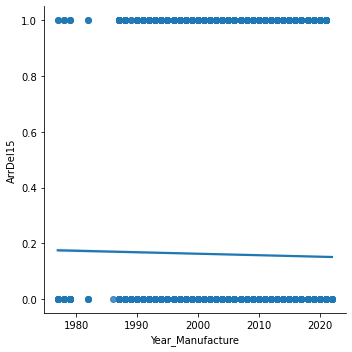

In [113]:
#Below is a visualization of our selections from above. 
#Keep in mind, we are just using a very simple regression model (standard model) to fit the line, this is more to demonstrate what it 'could' look like. When applying our different models we will see differences that are more noticable, such as the gradient of the line and they y-intercept. 

for i in selection_[1:]:
    #sns.scatterplot(x=selection_[0], y=i, data=df_feat);
    sns.lmplot(x=i, y=selection_[0], data=df_feat);


As we can see, there is little to infer from the visualization. There seems to be a relatively even spread between both years of manufacture as well as delay no dealy. Granted there is a lot of information being plotted so it's a bit hard to see. We will try and scatter plot it below to see if that improves it. 

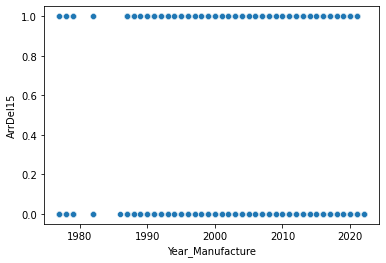

In [114]:
for i in selection_[1:]:
    sns.scatterplot(x=i, y=selection_[0], data=df_feat);

Still not that significant (visually), it's best to look at the pearson r and p-value. 

In [131]:
#let's look at the correlation expressed as numerics
#Modified from source: https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html

from scipy import stats
for i in selection_[1:]:
    print("Correlation between ",selection_[0],"and",i)
    print(stats.pearsonr(df_feat[selection_[0]], df_feat[i]))
#value 1: Pearson’s r
#value 2: A p-value. This is the probability that the true value of r is zero (no correlation).
#setting df_feat to 0, freeing up memory
df_feat = 0

Correlation between  ArrDel15 and Year_Manufacture
(-0.011928117048248598, 0.0)


To be honest, this is not that significant of a correlation unfortunately. Still worth including, but on it's own with not contribute significantly to a strong signal.  

In [116]:
#Let's now take the first digit of the flight number, we will keep it as a string since we will one-hot encode it
df['Flight_Number_Operating_Airline'] = df['Flight_Number_Operating_Airline'].astype(str).str[0]

In [117]:
# Analyzing data
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])

Number of Samples:  22602601
Number of features:  11


In [118]:
#storing for future use
feature_names_approach2= df.columns[1:]
feature_names_approach2

Index(['Airline', 'Dest', 'Origin', 'Month', 'DayOfWeek', 'DepTimeBlk',
       'AirTime', 'Distance', 'Flight_Number_Operating_Airline',
       'Year_Manufacture'],
      dtype='object')

In [119]:
# Sanity Check
df.head()

,ArrDel15,Airline,Dest,Origin,Month,DayOfWeek,DepTimeBlk,AirTime,Distance,Flight_Number_Operating_Airline,Year_Manufacture
0,0.0,Endeavor Air Inc.,ATL,ABY,1,2,1200-1259,38.0,145.0,3,2004.0
1,0.0,Endeavor Air Inc.,ABY,ATL,1,2,1000-1059,38.0,145.0,3,2004.0
2,1.0,Endeavor Air Inc.,EVV,ATL,1,6,0900-0959,54.0,350.0,3,2004.0
3,0.0,Endeavor Air Inc.,FAY,ATL,1,4,1700-1759,47.0,331.0,3,2004.0
4,0.0,Endeavor Air Inc.,ATL,FAY,1,4,1800-1859,59.0,331.0,3,2004.0


In [120]:
#We are going to standardize AirTime, Distance, and Year of Manufacture
#This is just to make it more suitable for different models
#With our decision tree models this is not a needed step, but there is no harm in applying so we can look at other models as well

from sklearn.preprocessing import MinMaxScaler

numeric_cols = ['AirTime','Distance','Year_Manufacture']
scaler = MinMaxScaler()
scaler.fit(df[numeric_cols])
df[numeric_cols] = scaler.transform(df[numeric_cols])
df.head()

,ArrDel15,Airline,Dest,Origin,Month,DayOfWeek,DepTimeBlk,AirTime,Distance,Flight_Number_Operating_Airline,Year_Manufacture
0,0.0,Endeavor Air Inc.,ATL,ABY,1,2,1200-1259,0.048091,0.020059,3,0.6
1,0.0,Endeavor Air Inc.,ABY,ATL,1,2,1000-1059,0.048091,0.020059,3,0.6
2,1.0,Endeavor Air Inc.,EVV,ATL,1,6,0900-0959,0.070721,0.055508,3,0.6
3,0.0,Endeavor Air Inc.,FAY,ATL,1,4,1700-1759,0.060820,0.052222,3,0.6
4,0.0,Endeavor Air Inc.,ATL,FAY,1,4,1800-1859,0.077793,0.052222,3,0.6


Let's take a similar approach to distance, and see what we can learn (especially after standardizing with minmaxscaler)

In [128]:
#Let's use this opportunity to look at the correlation between year_manufacture and delay
import seaborn as sns
print("selecting...")
selection_ = ['ArrDel15','Distance']
df_feat = df[selection_]
df_feat.columns = selection_
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])
#df_feat = df_feat.sample(frac=.1).reset_index(drop=True)
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])
# This should be the same, but because we are interchanging datasets this is kept in for safety. 

selecting...
Number of Samples:  22602601
Number of features:  2
Number of Samples:  22602601
Number of features:  2


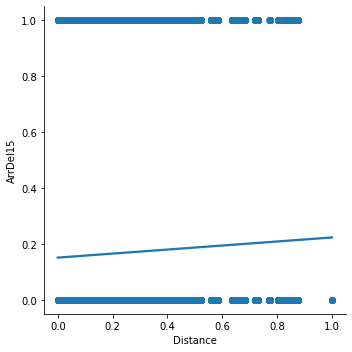

In [122]:
#Below is a visualization of our selections from above. 
#Keep in mind, we are just using a very simple regression model (standard model) to fit the line, this is more to demonstrate what it 'could' look like. When applying our different models we will see differences that are more noticable, such as the gradient of the line and they y-intercept. 

for i in selection_[1:]:
    #sns.scatterplot(x=selection_[0], y=i, data=df_feat);
    sns.lmplot(x=i, y=selection_[0], data=df_feat);


Again, nothing significant here, keep in mind we have normalized the data. Let's see if run as a scatterplot with slightly lighter data. 

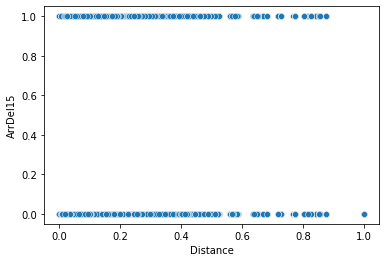

In [123]:
for i in selection_[1:]:
    sns.scatterplot(x=i, y=selection_[0], data=df_feat);

Still, little to observe here. So like before, we will look at the pearson r and p-value. 

In [129]:
#let's look at the correlation expressed as numerics
#Modified from source: https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html

from scipy import stats
for i in selection_[1:]:
    print("Correlation between ",selection_[0],"and",i)
    print(stats.pearsonr(df_feat[selection_[0]], df_feat[i]))
#value 1: Pearson’s r
#value 2: A p-value. This is the probability that the true value of r is zero (no correlation).
#setting df_feat to 0, freeing up memory
df_feat = 0

Correlation between  ArrDel15 and Distance
(0.018849778853048515, 0.0)


Also, not a significant correlation, but in aggregate it may start making a difference, let's proceed with one-hot encoding into categories. 

In [132]:
#We are going to one-hot encode the same features as before plus our new Flight_Number_Operating_Airline. 
df = pd.get_dummies(df, columns=['Month'], prefix="Month")
df = pd.get_dummies(df, columns=['DayOfWeek'], prefix="DayOfWeek")
df = pd.get_dummies(df, columns=['DepTimeBlk'], prefix="DepTimeBlk")
df = pd.get_dummies(df, columns=['Airline'], prefix="Airline")
df = pd.get_dummies(df, columns=['Origin'], prefix="Origin")
df = pd.get_dummies(df, columns=['Dest'], prefix="Dest")
df = pd.get_dummies(df, columns=['Flight_Number_Operating_Airline'], prefix="Flight_Number_Operating_Airline")

In [6]:
pd.set_option('display.max_columns', None)
#these are normally commented out, but get used during experimentation

#let's store this dataset for future use
#df.to_parquet('df_approach2_full.parquet')

#load code (when needed)
#df = pd.read_parquet('df_approach2_full.parquet', engine='auto')

In [7]:
#We are going to store a fraction of the data for analysis
#This is mainly due to resource limitations and to speed up initial observations

#taking a fraction of our data (data storage)
#df= df.sample(frac=.1).reset_index(drop=True)
#df.to_parquet('df_approach2_frac_10.parquet')

#load code (data retrieval)
#df = pd.read_parquet('df_approach2_frac_10.parquet', engine='auto')
df = pd.read_parquet('df_approach2_frac_10.parquet', engine='auto')
#...frac_20 implies a 20% sample of the dataset. 

In [8]:
# Sanity Check
df.head()

,ArrDel15,AirTime,Distance,Year_Manufacture,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_YUM,Flight_Number_Operating_Airline_1,Flight_Number_Operating_Airline_2,Flight_Number_Operating_Airline_3,Flight_Number_Operating_Airline_4,Flight_Number_Operating_Airline_5,Flight_Number_Operating_Airline_6,Flight_Number_Operating_Airline_7,Flight_Number_Operating_Airline_8,Flight_Number_Operating_Airline_9
0,0.0,0.135785,0.110496,0.822222,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,0.073550,0.052222,0.577778,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.0,0.247525,0.257998,0.977778,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,1.0,0.036775,0.019194,0.622222,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1.0,0.248939,0.208888,0.822222,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


This time, let's instead go straight to correlation observance instead of individual visualizations.

<u>Day of the Week Heat Map</u>

<AxesSubplot:>

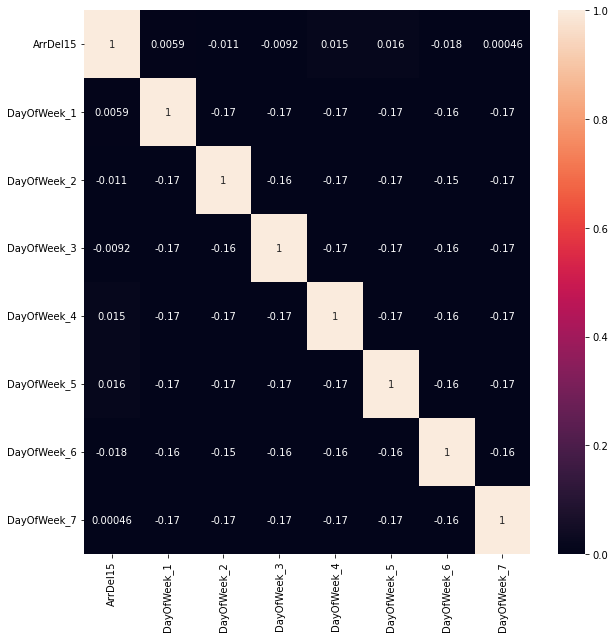

In [21]:
df2=df[['ArrDel15','DayOfWeek_1','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']]
plt.figure(figsize=(10,10))
heatmap(df2.corr(), vmin=0, vmax=1, annot=True, color='Red')

Looking at the first colum, we do not observe a significant correlation either way. We can see that Thursday and Friday are most positively correlated with a delay, and Tuesday and Saturday are inversely correlated. None of the features are significantly correlated. Nonetheless, it’s less likely we face a delay if we fly on Tuesday or Saturday. 


<u>Flight Number Operating Airline Heat Map</u>

<AxesSubplot:>

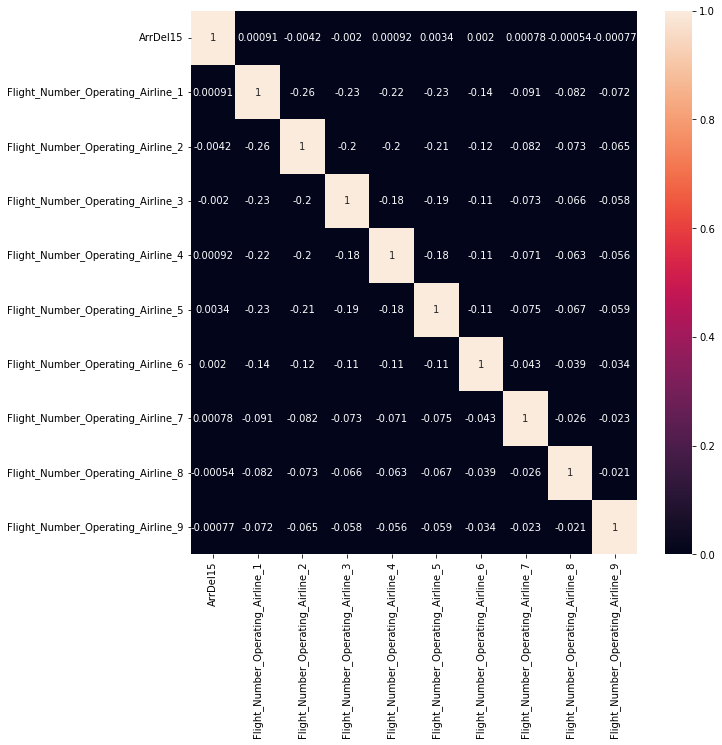

In [22]:
df2=df[['ArrDel15','Flight_Number_Operating_Airline_1','Flight_Number_Operating_Airline_2','Flight_Number_Operating_Airline_3','Flight_Number_Operating_Airline_4','Flight_Number_Operating_Airline_5','Flight_Number_Operating_Airline_6','Flight_Number_Operating_Airline_7','Flight_Number_Operating_Airline_8','Flight_Number_Operating_Airline_9']]
plt.figure(figsize=(10,10))
heatmap(df2.corr(), vmin=0, vmax=1, annot=True, color='Red')

Again, similar lack of significance as DayOfWeek, though it seems that flight number 2 seems to be least likely to experience a delay and flight number 5 most likely from a correlation perspective. Again, the values are practically insignificant to make any true claims here. 

<u>Month of Flight Heat Map</u>

<AxesSubplot:>

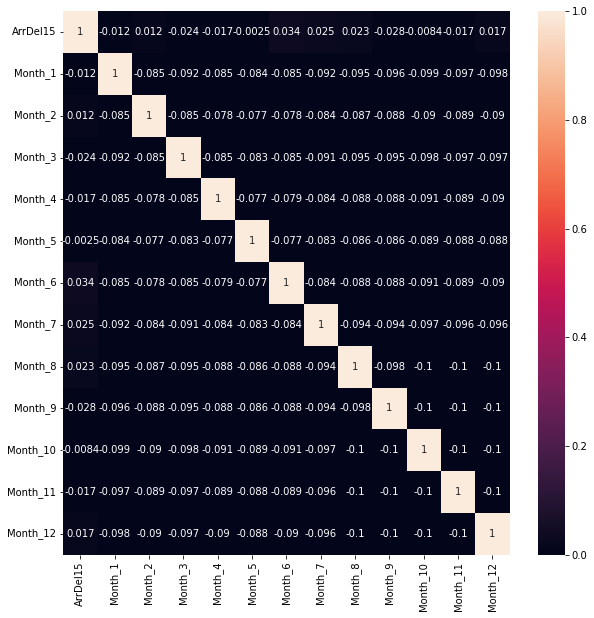

In [9]:
df2=df[['ArrDel15','Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']]
plt.figure(figsize=(10,10))
heatmap(df2.corr(), vmin=0, vmax=1, annot=True, color='Red')

Looking at the first column, we are again not observing anything significant. It seems that June is most correlated with flight delays (which is the start of summer holidays in the US). It seems that September is the most inversely correlated month (less delay). Again, the values are all relatively insignificant.

<u>Morning Flights Heat Map</u>

<AxesSubplot:>

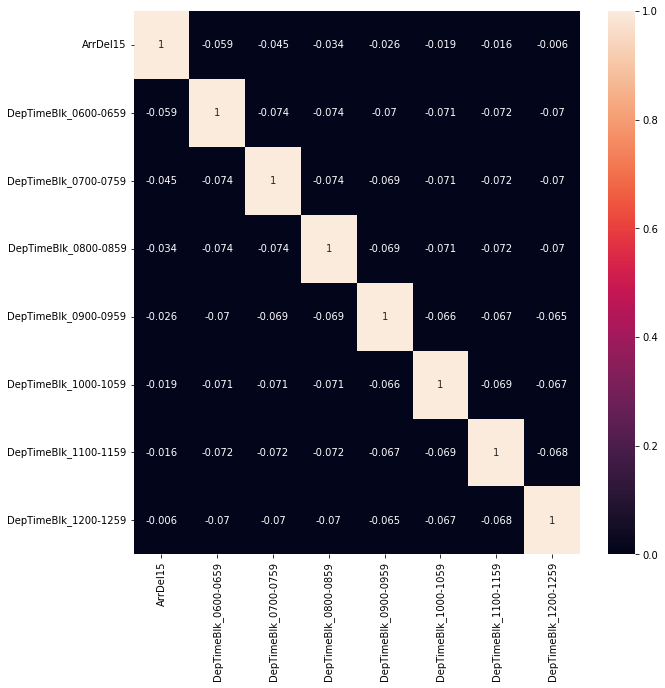

In [24]:
df2=df[['ArrDel15','DepTimeBlk_0600-0659','DepTimeBlk_0700-0759','DepTimeBlk_0800-0859','DepTimeBlk_0900-0959','DepTimeBlk_1000-1059','DepTimeBlk_1100-1159','DepTimeBlk_1200-1259']]
plt.figure(figsize=(10,10))
heatmap(df2.corr(), vmin=0, vmax=1, annot=True, color='Red')

Similar observation to previous heat maps, there are no strong correlations to observe. it seems that 0600-0659 is the most inversely correlated (best time to fly) and 1200-1259 the least (arguable worst). Again, no significant correlation here. 

<u>Select Airports Heat Map</u>

<AxesSubplot:>

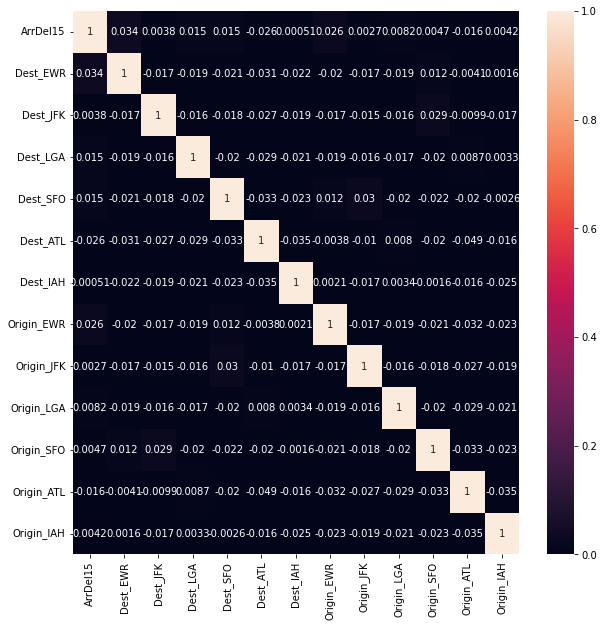

In [25]:
df2=df[['ArrDel15','Dest_EWR','Dest_JFK','Dest_LGA','Dest_SFO','Dest_ATL','Dest_IAH','Origin_EWR','Origin_JFK','Origin_LGA','Origin_SFO','Origin_ATL','Origin_IAH']]
plt.figure(figsize=(10,10))
heatmap(df2.corr(), vmin=0, vmax=1, annot=True, color='Red')

Maybe some popular airports by both destination and origin classification we do not observe anything significant. Sure, EWR seemsmost significantly correlated (looking at dest/orig), but there is little to observe here. 

<u>Airtime/Distance Heat Map</u>

<AxesSubplot:>

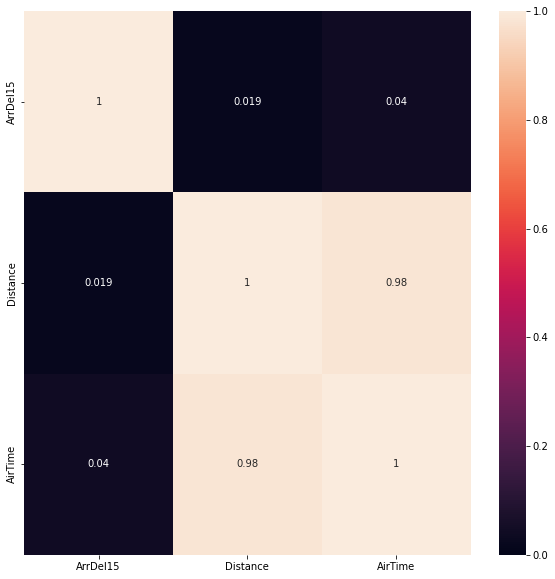

In [26]:
df2=df[['ArrDel15','Distance','AirTime']]
plt.figure(figsize=(10,10))
heatmap(df2.corr(), vmin=0, vmax=1, annot=True, color='Red')

We can see here that while we believe distance matters, it's still not going to generate a very strong signal for our models. It is possible that in aggregate we can improve from our existing score, but I do not expect us to see any 'ground-breaking' improvements. 

###### Training with newly selected feature set

Now that we have included additional features, let's retrain our model

In [5]:
#imports
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260260 entries, 0 to 2260259
Columns: 821 entries, ArrDel15 to Flight_Number_Operating_Airline_9
dtypes: float64(4), uint8(817)
memory usage: 1.8 GB


In [11]:
# Like before, not expected to cause new drops, but due to many dataset switching during experimentation, kept it in.
df=df.dropna().reset_index(drop=True)

In [12]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260260 entries, 0 to 2260259
Columns: 821 entries, ArrDel15 to Flight_Number_Operating_Airline_9
dtypes: float64(4), uint8(817)
memory usage: 1.8 GB


In [13]:
# Only our 15 minute delay is part of the y set, all our entries are part of the x set. 
y = df.values[:,0]
X = df.values[:, 1:]

In [14]:
#storing for future graphing purposes
feature_names_ = df.columns[1:]
class_names_ = df.ArrDel15.unique()
feature_names_
del[[df]] #clearing memory

In [15]:
#Under sampling
#from https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 

print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 1897712, 1.0: 362548})
Resampled dataset shape Counter({0.0: 362548, 1.0: 362548})


Remember from our first run through just how imbalanced the dataset is. 

In [16]:
# We are creating our train,validation, and test sets here. Striving for the same 60,20,20 division

test_size_ = 0.2
random_state_ = 42


X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=test_size_,random_state=random_state_)

#now split the 80 training set (20 to val) making it 60,20,20
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=random_state_)

#clear memory
X = 0
y = 0
X_res = 0
y_res = 0

In [17]:
#model selection
#Gaussian required 1.8TB of ram
#SVM requires significant computational time
models_ = [LogisticRegression(max_iter=5000), SGDClassifier(), KNeighborsClassifier(),DecisionTreeClassifier(),AdaBoostClassifier(),CatBoostClassifier(task_type="GPU"),LGBMClassifier(),XGBClassifier(),GradientBoostingClassifier(),RandomForestClassifier(),MLPClassifier()]

We had to remove the naive-bayes classification model due to memory issues. 

In [ ]:
#Run multiple models with default params to see what we get
df_comb = run_model_set(False,False)

In [176]:
df_comb

,Model,Acc_train,Acc_validation,Acc_test,Precision Test,Recall Test,F1 Test
0,Logistic Regression,0.625162,0.624438,0.625277,0.624436,0.624437,0.624436
1,SGD Classifier,0.599887,0.598779,0.599790,0.598896,0.598711,0.598563
2,K-Neighbors,0.728169,0.572183,0.572821,0.572174,0.572163,0.572156
3,DecisionTree,0.999798,0.558530,0.559885,0.558527,0.558528,0.558527
4,AdaBoost,0.599738,0.598835,0.600135,0.598834,0.598811,0.598799
5,CatBoost,0.629364,0.625714,0.626421,0.625710,0.625710,0.625710
6,LGBM,0.631798,0.627803,0.629049,0.627905,0.627841,0.627768
7,XGB,0.649940,0.631837,0.631848,0.631980,0.631882,0.631783
8,GradientBoost,0.607125,0.605027,0.607189,0.605463,0.604912,0.604463
9,Random Forest,0.999795,0.609578,0.609913,0.609716,0.609625,0.609513


We are noticing some improvement but nothing really significant. However, we are going to try and tune parameters more. 

In [ ]:
depth_ = 16
iterations_ = 5000
learning_rate_ = 0.01
bagging_temperature_ = 1
l2_leaf_reg_ = 1
leaf_estimation_method_ = 'Newton'

model = CatBoostClassifier(task_type="GPU",depth=depth_,iterations=iterations_,learning_rate=learning_rate_,bagging_temperature=bagging_temperature_,l2_leaf_reg=l2_leaf_reg_,leaf_estimation_method=leaf_estimation_method_)
#model = CatBoostClassifier()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')


In [27]:
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.8010628492358473
Mean Accuracy Test 0.637250034478003
Mean Accuracy Validate 0.6391300450285825
Precision Test 0.637250034478003
Recall Test 0.637250034478003
fscore Test 0.637250034478003


We ended up overfitting here a lot. Let's tweak a little further. reducing depth a bit, and modifying learning rate and number of iterations. Note again that mean accuracy on the test data is equal to precision, recall, and fscore. 

In [ ]:
depth_ = 15
iterations_ = 5000
learning_rate_ = 0.05
bagging_temperature_ = 1
l2_leaf_reg_ = 1
leaf_estimation_method_ = 'Newton'

model = CatBoostClassifier(task_type="GPU",depth=depth_,iterations=iterations_,learning_rate=learning_rate_,bagging_temperature=bagging_temperature_,l2_leaf_reg=l2_leaf_reg_,leaf_estimation_method=leaf_estimation_method_)
#model = CatBoostClassifier()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')


In [14]:
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.9910609414398573
Mean Accuracy Test 0.6214866914908288
Mean Accuracy Validate 0.6202014908391315
Precision Test 0.6214866914908288
Recall Test 0.6214866914908288
fscore Test 0.6214866914908288


Below is the feature important for the above model. We can see how AirTime and Distance (both related) seem to be significantly driving importants with otherwise morning departure slots. Year_manufacture is still an important feature but less significant than certain departure slots as well as earlines (Delta & Southwest). Keep in mind we have an overfitted model. 

In [18]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

pd.DataFrame({'feature_importance': model.get_feature_importance(), 
              'feature_names': feature_names_}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(50)


,feature_importance,feature_names
0,20.064481,AirTime
1,17.464056,Distance
23,7.200211,DepTimeBlk_0600-0659
24,4.405276,DepTimeBlk_0700-0759
25,2.624049,DepTimeBlk_0800-0859
48,2.617038,Airline_Delta Air Lines Inc.
62,2.475990,Airline_Southwest Airlines Co.
22,2.316090,DepTimeBlk_0001-0559
8,1.846000,Month_6
26,1.703334,DepTimeBlk_0900-0959


As mentioned, the above is very overfitted. Let's try a real drop in learning rate and more importantly depth (going from 15 deep to 10).

In [ ]:
depth_ = 10
iterations_ = 1000
learning_rate_ = 0.001
bagging_temperature_ = 2
l2_leaf_reg_ = 2
leaf_estimation_method_ = 'Newton'

model = CatBoostClassifier(task_type="GPU",depth=depth_,iterations=iterations_,learning_rate=learning_rate_,bagging_temperature=bagging_temperature_,l2_leaf_reg=l2_leaf_reg_,leaf_estimation_method=leaf_estimation_method_)
#model = CatBoostClassifier()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')


In [16]:
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.5922718172561297
Mean Accuracy Test 0.5905461315680596
Mean Accuracy Validate 0.5929567849730035
Precision Test 0.5905461315680596
Recall Test 0.5905461315680596
fscore Test 0.5905461315680596


While we are no longer really overfitting, we are experiencing a drop in recall. We may have been overly aggresive in our learning_rate parameter, let's reduce.

In [ ]:
depth_ = 10
iterations_ = 1000
learning_rate_ = 0.001
bagging_temperature_ = 2
l2_leaf_reg_ = 2
leaf_estimation_method_ = 'Newton'

model = CatBoostClassifier(
    task_type="GPU",
    early_stopping_rounds=50,
    eval_metric="Precision",
    auto_class_weights="Balanced",
    thread_count=-1
)
#model = CatBoostClassifier()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')


In [19]:
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.6293313289982692
Mean Accuracy Test 0.625975727485864
Mean Accuracy Validate 0.626269661216806
Precision Test 0.625975727485864
Recall Test 0.625975727485864
fscore Test 0.625975727485864


As we can see, we are now much more 'in sync' across the board. When looking at feature important below, we now see the early departure slots as being more significant than airTime and Distance. In face, the 0600-0659 block seems to carry high significant compared to others. Besides flight number 1 and 2, no other flight numbers are present in the list, and even those numbers carry little significance in this trained model.

In [25]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

pd.DataFrame({'feature_importance': model.get_feature_importance(), 
              'feature_names': feature_names_}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(50)


,feature_importance,feature_names
23,16.889534,DepTimeBlk_0600-0659
24,10.673303,DepTimeBlk_0700-0759
0,8.549541,AirTime
25,7.689016,DepTimeBlk_0800-0859
22,6.465430,DepTimeBlk_0001-0559
1,5.740252,Distance
48,5.633734,Airline_Delta Air Lines Inc.
26,5.301885,DepTimeBlk_0900-0959
62,5.055730,Airline_Southwest Airlines Co.
27,4.193970,DepTimeBlk_1000-1059


Let's do a more comprehensive search for optimal parameters using a gridsearch. From our previous work we have gained an idea on various parameter settings to try. 

In [ ]:
#note: previous versions were run with 1,000 and 1,400 iterations as well as a few additional parameters. 
#This is a stripped down version to provide a very high level review for tuning. I noticed, that while there were differences
#between the iterations, it merely was directional in terms of performance, that is the relationships between parameters
#held true and consistent regardless of iterations, but additional iterations appears to increase (mostly) F1 and
#classification accuracy. 

import warnings
warnings.filterwarnings("ignore") #for fit failures that may occur

#modified from article: https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-classification
#oblivious_tree_options.cpp:125: Maximum tree depth is 16
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

#See catboost.ai source for documentation: https://catboost.ai/en/docs/references/training-parameters/
#iterations default 1000
#min_data_in_leaf default 1
#learning rate (eta) default 0.03
#l2 leaf reg default 3
#bagging temp default 1
#depth default 16 (cpu limited to 16)

#CBC = CatBoostClassifier(task_type="GPU",devices='0:1')
#CBC = CatBoostClassifier(task_type= 'GPU')
CBC = CatBoostClassifier()

parameters = {'task_type':['GPU'],'leaf_estimation_method':['Newton','Gradient'],'depth':[10,12,14,16],'l2_leaf_reg':[2,3,5],'bagging_temperature':[0.75,1,2],'learning_rate':[0.001,0.01,0.05,0.1],'iterations':[500],'min_data_in_leaf':[1,2,4]}

#Note: Our parameters are defined above, I included the defaults as well. n_jobs set to one in order to manage the load
# and verbose set to 10 (anything greater than 3 provides high verbose level)
# cv = 2 means that for our cross-validation splitting strategy we are using 2 folds in our kfold. This is our 'way' of testing 
# our training set. Do note, this isn't the same as running it against an entire test or validation set. Though, for
# the preliminary setup of this project, I feel it is sufficient. 
# For more info see here:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/glossary.html#term-CV-splitter
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=1,verbose=10)
Grid_CBC.fit(X_train, y_train)

In [19]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.6315885045668335

 The best parameters across ALL searched params:
 {'bagging_temperature': 0.75, 'depth': 10, 'iterations': 500, 'l2_leaf_reg': 5, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.1, 'min_data_in_leaf': 2, 'task_type': 'GPU'}


Let's implement the above learnings into our model so we can extract more detailed information. Please note we are boosting iterations from 500 to 2000. The initial reduction was part of a time consideration as gridsearch has so many possible combinations it requires a significant amount of computer time.

In [ ]:
depth_ = 10
iterations_ = 2000
learning_rate_ = 0.09
bagging_temperature_ = 0.75
l2_leaf_reg_ = 5
min_data_in_leaf_ = 2
leaf_estimation_method_ = 'Newton'

#model = CatBoostClassifier(depth=depth_,iterations=iterations_,learning_rate=learning_rate_,bagging_temperature=bagging_temperature_,l2_leaf_reg=l2_leaf_reg_,leaf_estimation_method=leaf_estimation_method_)
model = CatBoostClassifier(task_type="GPU",min_data_in_leaf=min_data_in_leaf_,depth=depth_,iterations=iterations_,learning_rate=learning_rate_,bagging_temperature=bagging_temperature_,l2_leaf_reg=l2_leaf_reg_,leaf_estimation_method=leaf_estimation_method_)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')

In [27]:
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.7486605203456099
Mean Accuracy Test 0.6386981106054337
Mean Accuracy Validate 0.6386335583613182
Precision Test 0.6386981106054337
Recall Test 0.6386981106054337
fscore Test 0.6386981106054337


We observe that your additional of 'Year_Manufacture' lead to being the 4th most important feature. Interestingly, the flight number does not appear to be a significant feature. We are however overfitting again. This is one of the issues with the setup of gridsearch we used. It was mainfully focused on a high accuracy score and pays no regard to any potential overfitting risks.

##  Evaluating Concept Drift / Prediction Shift

One important notion we raised at the beginning of the project is whether or not there is concept drift. That is, is there a stable pattern/state of doing within the US Domestic Airline industry that allows for some signal generation that was upended during the pandemic. We posit that, yes, data acquired during 2020 and 2021 will include a lot of noise and a temporal drift. Our suspicion is that 2023 onward we would see behavior that is more similar to 2019 and prior years. However, we cannot be sure. It is very possible that there were logistical and commercial learnings made by Airline companies and airport infrastructure that will materially change flight behavior in the future. At this point in time we just don't know. However, we do have 4 years of data that has been pre-processed, let's look at **just 2018 and 2019** to observe whether or not there is any markable changes to our prediction performance. 

In [3]:
#reload imports from scratch

# Imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
#importing our data from disk
df_2018 = pd.read_parquet('Combined_Flights_2018.parquet', engine='auto')
df_2019 = pd.read_parquet('Combined_Flights_2019.parquet', engine='auto')

#We are omitting pandemic years 2020 and 2021
#df_2020 = pd.read_parquet('Combined_Flights_2020.parquet', engine='auto')
#df_2021 = pd.read_parquet('Combined_Flights_2021.parquet', engine='auto')

pd.set_option('display.max_columns', None)
df_2018.tail()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
637609,2018-09-11,Air Wisconsin Airlines Corp,SCE,IAD,False,False,1445,1433.0,0.0,-12.0,1515.0,0.0,35.0,61.0,42.0,133.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3839,ZW,20046,ZW,N437AW,3839,14711,1471105,34711,"State College, PA",PA,42,Pennsylvania,23,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,0.0,-1.0,1400-1459,4.0,1437.0,1512.0,3.0,1546,-31.0,0.0,-2.0,1500-1559,1,0.0
637610,2018-09-11,Air Wisconsin Airlines Corp,IAD,GSO,False,False,1235,1224.0,0.0,-11.0,1344.0,0.0,43.0,80.0,80.0,239.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3838,ZW,20046,ZW,N410AW,3838,12264,1226402,30852,"Washington, DC",VA,51,Virginia,38,11995,1199502,31995,"Greensboro/High Point, NC",NC,37,North Carolina,36,0.0,-1.0,1200-1259,30.0,1254.0,1337.0,7.0,1355,-11.0,0.0,-1.0,1300-1359,1,0.0
637611,2018-09-11,Air Wisconsin Airlines Corp,EVV,ORD,False,False,1030,1016.0,0.0,-14.0,1137.0,0.0,54.0,94.0,81.0,272.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3837,ZW,20046,ZW,N467AW,3837,11612,1161206,31612,"Evansville, IN",IN,18,Indiana,42,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,0.0,-1.0,1000-1059,20.0,1036.0,1130.0,7.0,1204,-27.0,0.0,-2.0,1200-1259,2,0.0
637612,2018-09-11,Air Wisconsin Airlines Corp,ORD,HPN,False,False,1410,1403.0,0.0,-7.0,1717.0,0.0,104.0,136.0,134.0,738.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3837,ZW,20046,ZW,N440AW,3837,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,12197,1219702,31703,"White Plains, NY",NY,36,New York,22,0.0,-1.0,1400-1459,25.0,1428.0,1712.0,5.0,1726,-9.0,0.0,-1.0,1700-1759,3,0.0
637613,2018-09-11,Air Wisconsin Airlines Corp,HPN,ORD,False,False,1800,1754.0,0.0,-6.0,1919.0,0.0,116.0,153.0,145.0,738.0,2018,3,9,11,2,UA,UA_CODESHARE,19977,UA,3836,ZW,20046,ZW,N440AW,3836,12197,1219702,31703,"White Plains, NY",NY,36,New York,22,13930,1393006,30977,"Chicago, IL",IL,17,Illinois,41,0.0,-1.0,1800-1859,14.0,1808.0,1904.0,15.0,1933,-14.0,0.0,-1.0,1900-1959,3,0.0


In [8]:
#We are also going to consider arrival delays beyond 3 hours to be the equivalent to a cancellation and/or an alternative flight.
df_2018 = df_2018.loc[df_2018['ArrDelayMinutes'] <= 180]
df_2019 = df_2019.loc[df_2019['ArrDelayMinutes'] <= 180]

#Let's first import our new set of features
df_2018 = df_2018[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number']]
df_2019 = df_2019[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number']]

#concat our individual dataframes into one master and drop Nan values (remember no 2020 and 2021)
df = pd.concat([df_2018,df_2019])
df=df.dropna().reset_index(drop=True)
del [[df_2018,df_2019]] #free up memory


In [9]:
#remove any zero distance values since they are non-relevant
df = df.loc[df['Distance'] > 0]

#Let's now take the first digit of the flight number, we will keep it as a string since we will one-hot encode it
df['Flight_Number_Operating_Airline'] = df['Flight_Number_Operating_Airline'].astype(str).str[0]

In [10]:
#We are now going to merge data from an FAA database that includes year of manufacture, we are using tail number as a key
#source: https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download

# Reading Data
#MASTER.txt has been formatted as a CSV to simplify our import
df_tail = pd.read_csv('MASTER.txt',dtype=str)
df_tail = df_tail[['N-NUMBER','YEAR MFR']]

df_tail['N-NUMBER'] = 'N' + df_tail['N-NUMBER'].astype(str)

df_tail['N-NUMBER'] = df_tail['N-NUMBER'].str.replace(" ", "")

df_tail = df_tail.rename(columns={'N-NUMBER': 'Tail_Number'})
df_tail = df_tail.rename(columns={'YEAR MFR': 'Year_Manufacture'})

df = pd.merge(df, df_tail, on='Tail_Number')

pd.set_option('display.max_columns', None)

#our new feature set
df = df[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Year_Manufacture']]
del [[df_tail]]#free up memory

#de-bugging
#df = df.rename(columns={'Year_Manufacture_x': 'Year_Manufacture'})

#the data was stored as a string in the FAA database, let turn it into a number.
df['Year_Manufacture'] = pd.to_numeric(df['Year_Manufacture'], errors='coerce')
#remove any zero year values
df = df.loc[df['Year_Manufacture'] > 0]


In [11]:
print("selecting...")
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])
df=df.dropna().reset_index(drop=True)
#df_feat = df_feat.sample(frac=.01).reset_index(drop=True)
print("Number of Samples: ", df_feat.shape[0])
print("Number of features: ", df_feat.shape[1])
# We should not notice a difference here, but this is kept in because during experimentation
# we were swapping datasets/frames around


selecting...
Number of Samples:  12299845
Number of features:  2
Number of Samples:  12299845
Number of features:  2


In [12]:
#We are going to standardize AirTime, Distance, and Year of Manufacture
#This is just to make it more suitable for different models
#With our decision tree models this is not a needed step, but there is no harm in applying so we can look at other models as well

from sklearn.preprocessing import MinMaxScaler

numeric_cols = ['AirTime','Distance','Year_Manufacture']
scaler = MinMaxScaler()
scaler.fit(df[numeric_cols])
df[numeric_cols] = scaler.transform(df[numeric_cols])
df.head()

,ArrDel15,Airline,Dest,Origin,Month,DayOfWeek,DepTimeBlk,AirTime,Distance,Flight_Number_Operating_Airline,Year_Manufacture
0,0.0,Endeavor Air Inc.,ATL,ABY,1,2,1200-1259,0.048641,0.022512,3,0.6
1,0.0,Endeavor Air Inc.,ABY,ATL,1,2,1000-1059,0.048641,0.022512,3,0.6
2,1.0,Endeavor Air Inc.,EVV,ATL,1,6,0900-0959,0.071531,0.062994,3,0.6
3,0.0,Endeavor Air Inc.,FAY,ATL,1,4,1700-1759,0.061516,0.059242,3,0.6
4,0.0,Endeavor Air Inc.,ATL,FAY,1,4,1800-1859,0.078684,0.059242,3,0.6


In [13]:
#We are going to one-hot encode the same features as before. 
df = pd.get_dummies(df, columns=['Month'], prefix="Month")
df = pd.get_dummies(df, columns=['DayOfWeek'], prefix="DayOfWeek")
df = pd.get_dummies(df, columns=['DepTimeBlk'], prefix="DepTimeBlk")
df = pd.get_dummies(df, columns=['Airline'], prefix="Airline")
df = pd.get_dummies(df, columns=['Origin'], prefix="Origin")
df = pd.get_dummies(df, columns=['Dest'], prefix="Dest")
df = pd.get_dummies(df, columns=['Flight_Number_Operating_Airline'], prefix="Flight_Number_Operating_Airline")


In [4]:
#We are going to store a fraction of the data for analysis
#This is mainly due to resource limitations and to speed up initial observations.
#While before we could not always work with a set greater than 20% with two entire years omitted we are 
#going to try with 40%.

#taking a fraction of our data (data storage)
#df= df.sample(frac=.4).reset_index(drop=True)
#df.to_parquet('df_drift_frac_40.parquet')

#load code (data retrieval)
#df = pd.read_parquet('df_drift_frac_50.parquet', engine='auto')
df = pd.read_parquet('df_drift_frac_40.parquet', engine='auto')
#...frac_20 implies a 20% sample of the dataset. 

In [5]:
#imports
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919938 entries, 0 to 4919937
Columns: 795 entries, ArrDel15 to Flight_Number_Operating_Airline_9
dtypes: float64(4), uint8(791)
memory usage: 3.8 GB


In [7]:
# Like before, not expected to cause new drops, but due to many dataset switching during experimentation, kept it in.
df=df.dropna().reset_index(drop=True)

<u>Performing our analysis</u>

In [8]:
# Only our 15 minute delay is part of the y set, all our entries are part of the x set. 
y = df.values[:,0]
X = df.values[:, 1:]

In [9]:
#storing for future graphing purposes
feature_names_ = df.columns[1:]
class_names_ = df.ArrDel15.unique()
feature_names_
del[[df]] #clearing memory

In [10]:
#Under sampling
#from https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 

print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))


Original dataset shape Counter({0.0: 4016193, 1.0: 903745})
Resampled dataset shape Counter({0.0: 903745, 1.0: 903745})


An observation to keep in mind here is that our ratio of no-delay/delay is roughly equal to when we included 2020 and 2021. However, the 'hunch' is that that the concept constructing the reason for delay may not be the same. 

In [11]:
# We are creating our train,validation, and test sets here. Striving for the same 60,20,20 division

test_size_ = 0.2
random_state_ = 42


X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=test_size_,random_state=random_state_)

#now split the 80 training set (20 to val) making it 60,20,20
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=random_state_)

#clear memory
X = 0
y = 0
X_res = 0
y_res = 0


In [12]:
#model selection
#Gaussian required 1.8TB of ram
#SVM requires significant computational time
models_ = [LogisticRegression(max_iter=5000), SGDClassifier(), KNeighborsClassifier(),DecisionTreeClassifier(),AdaBoostClassifier(),CatBoostClassifier(task_type="GPU"),LGBMClassifier(),XGBClassifier(),GradientBoostingClassifier(),RandomForestClassifier(),MLPClassifier()]

In [ ]:
#Run multiple models with default params to see what we get
df_comb = run_model_set(False,False)


In [24]:
df_comb

,Model,Acc_train,Acc_validation,Acc_test,Precision Test,Recall Test,F1 Test
0,Logistic Regression,0.630758,0.629099,0.630136,0.629119,0.629098,0.629083
1,SGD Classifier,0.595206,0.595160,0.594720,0.596456,0.595151,0.593782
2,K-Neighbors,0.735233,0.588919,0.590371,0.588932,0.588918,0.588902
3,DecisionTree,0.999160,0.570969,0.572330,0.570969,0.570969,0.570969
4,AdaBoost,0.605586,0.604772,0.605279,0.605409,0.604767,0.604167
5,CatBoost,0.634382,0.632109,0.632905,0.632344,0.632105,0.631941
6,LGBM,0.637816,0.634958,0.636446,0.634958,0.634958,0.634958
7,XGB,0.650168,0.641827,0.643282,0.641827,0.641826,0.641826
8,GradientBoost,0.611238,0.609926,0.610357,0.612074,0.609916,0.608035
9,Random Forest,0.999156,0.615882,0.618355,0.615925,0.615883,0.615848


This is fascinating! When removing the 'pandemic years' from our data, we observe the highest F1 and accuracy with MLP. Looking at recall, which I value highly, XGB now enjoys highest values. Though the difference is absurdly slight. Let's look at MLP a bit closer.

In [25]:
model = MLPClassifier()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')


In [26]:
#50%
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.6890992481286203
Mean Accuracy Test 0.6397518105217733
Mean Accuracy Validate 0.6421142025682023
Precision Test 0.6397518105217733
Recall Test 0.6397518105217733
fscore Test 0.6397518105217733


This is performance with the default params, lets do a gridsearch to see if we can find more optimal hyper parameters.

In [22]:
#modified from article: https://www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-classification
#oblivious_tree_options.cpp:125: Maximum tree depth is 16
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

MLP = MLPClassifier()
#'leaf_estimation_method':['newton','gradient']
parameters = {'solver':['lbfgs','sgd','adam'],'hidden_layer_sizes':[100,200],'alpha':[0.0001,0.00001,0.001,0.01,0.1],'learning_rate':['constant','invscaling','adaptive']}

Grid_MLP = GridSearchCV(estimator=MLP, param_grid = parameters, verbose = 10, cv = 2, n_jobs=22)
Grid_MLP.fit(X_train, y_train)

Fitting 2 folds for each of 90 candidates, totalling 180 fits


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=2, estimator=MLPClassifier(), n_jobs=22,
             param_grid={'alpha': [0.0001, 1e-05, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [100, 200],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=10)

In [23]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_MLP.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_MLP.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_MLP.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 MLPClassifier(alpha=0.01, hidden_layer_sizes=100, learning_rate='adaptive',
              solver='sgd')

 The best score across ALL searched params:
 0.6458588060422649

 The best parameters across ALL searched params:
 {'alpha': 0.01, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'solver': 'sgd'}


Based on the above let's use for our hyper parameters and pull more details on model performance. We are also going to visualize the confusion matric and ROC AUC scores. Keep in mind that a greater AUC score indicated the better model performs at different threshold points between positive and negative classes. We will see below that they all fall within a reasonable margin of each other. Interesting to note that our stochastic gradient descent solver was still considered 'best' even do we hit our max_iter without convergence. We could re-approach with a more complex model. However, we will be hitting limitations of our computational hardware. This gridsearch for example required 30 CPU cores and 200GB of ram. 

<u>MLP Classifier Results</u>

In [14]:
import warnings
warnings.filterwarnings("ignore") #for fit failures that may occur
solver_ = 'sgd'
hidden_layer_sizes_ = 100
alpha_ = 0.01
learning_rate_ = 'adaptive'

model = MLPClassifier(solver=solver_,hidden_layer_sizes=hidden_layer_sizes_,alpha=alpha_,learning_rate=learning_rate_)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')


In [15]:
#50%
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.6661779594907855
Mean Accuracy Test 0.6493673547294867
Mean Accuracy Validate 0.6513369368571887
Precision Test 0.6493673547294867
Recall Test 0.6493673547294867
fscore Test 0.6493673547294867


Text(0.5, 257.44, 'Predicted label')

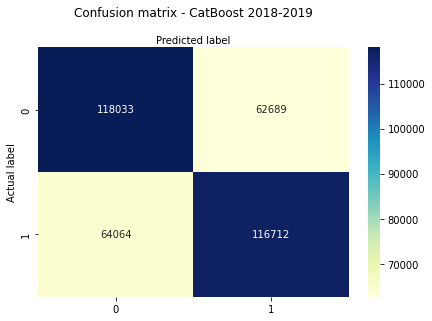

In [16]:
# import the metrics class
from sklearn import metrics
y_pred = model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
#example diagrams from: https://www.datacamp.com/tutorial/understanding-logistic-regression-python

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - CatBoost 2018-2019', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [17]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

0.6493679150838356

<u>XGB Classifier Results</u>

In [48]:
model =  XGBClassifier()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')

In [44]:
#50%
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.6501677279911184
Mean Accuracy Test 0.6418265107967402
Mean Accuracy Validate 0.6432815672562504
Precision Test 0.6418265107967402
Recall Test 0.6418265107967402
fscore Test 0.6418265107967402


Text(0.5, 257.44, 'Predicted label')

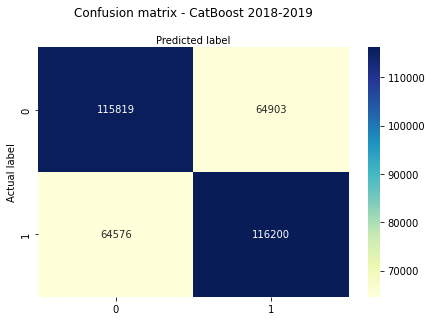

In [49]:
# import the metrics class
from sklearn import metrics
y_pred = model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
#example diagrams from: https://www.datacamp.com/tutorial/understanding-logistic-regression-python

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - CatBoost 2018-2019', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

0.6418263676813496

<u>CatBoost Classifier Results</u>

In [ ]:
model =  CatBoostClassifier(task_type="GPU")
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')

In [16]:
#50%
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.6343963175453253
Mean Accuracy Test 0.632299487134092
Mean Accuracy Validate 0.6331321335111121
Precision Test 0.632299487134092
Recall Test 0.632299487134092
fscore Test 0.632299487134092


Text(0.5, 257.44, 'Predicted label')

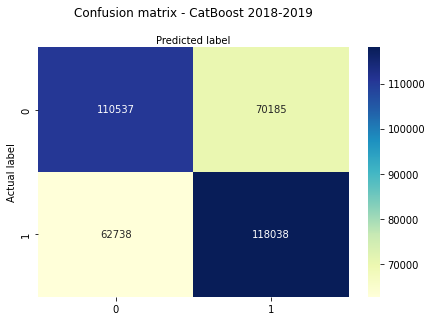

In [17]:
# import the metrics class
from sklearn import metrics
y_pred = model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix
#example diagrams from: https://www.datacamp.com/tutorial/understanding-logistic-regression-python

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - CatBoost 2018-2019', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

0.6322964016753917

To re-iterate we notice no significant differences in AUC scores, between the models they all perform relatively similar. The confusion matrix provides us visual assistance on observing the predicted outcome. Remember a prediction of 1 means delay, and an actual label outcome of 0 means no delay. We really want the LOWER LEFT quadrant of the confusion matrix to be as low as possible! Interestingly enough, the CatBoost model has the lowest (1 actual, 0 predicted) value. Since we had such success with CatBoost in our previous approach, we are going to revisit.

**We are going to re-approach our CatBoost model using this dataset, and tuned hyper parameters to see what we can produce as a result.** 

<u>Tuned CatBoost Classifier Results</u>

In [ ]:
depth_ = 12
iterations_ = 1000
learning_rate_ = 0.01
bagging_temperature_ = 2
l2_leaf_reg_ = 2
leaf_estimation_method_ = 'Newton'

model = CatBoostClassifier(task_type="GPU",depth=depth_,iterations=iterations_,learning_rate=learning_rate_,bagging_temperature=bagging_temperature_,l2_leaf_reg=l2_leaf_reg_,leaf_estimation_method=leaf_estimation_method_)
#model = CatBoostClassifier()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')


In [21]:
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.7101500186904103
Mean Accuracy Test 0.695134638509451
Mean Accuracy Validate 0.6929120559901639
Precision Test 0.6942147274184752
Recall Test 0.6976432174523148
fscore Test 0.6962137486592332


This is quite the improvement! We are approaching a 70% accuracy in correctly classifying a flight as delayed or not delayed. We notice that our Training accuracy is only slightly overfitted (purely based on the accuracy comparison between test and train). We notice that recall is very slightly higher than precision, but still at .697 it's also approaching 70. Let's take a look at the feature importance.

We are going to run the model below to highlight feature importance (limited to 50 entries). We may expect some variations in order. Let's observe:

In [28]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

pd.DataFrame({'feature_importance': model.get_feature_importance(), 
              'feature_names': feature_names_}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(50)


,feature_importance,feature_names
0,10.943754,AirTime
2,9.685015,Year_Manufacture
1,9.647587,Distance
62,2.534452,Airline_Southwest Airlines Co.
811,2.293497,Flight_Number_Operating_Airline_1
812,1.743203,Flight_Number_Operating_Airline_2
18,1.660315,DayOfWeek_4
21,1.637334,DayOfWeek_7
19,1.632098,DayOfWeek_5
15,1.593576,DayOfWeek_1


We now observe AirTime, Year_Manufacture, and Distance as the top three features. Note this are ones we added during our second approach. Interestingly the flight number and airline are now more significant as well. We also see a slightly more even spread in feature significance. Previously certain features rates almost twice as high as the 2nd ranked feature. This is no longer the case. We may have removed quite some noise by omitting 2020 and 2021. 

<u>General Discussion on third approach (years 2018-2019 only)</u>

While we do not notice a significant uplift with default parameters, there is still some gain. More interestingly, MLP a feed-forward artificial neural network alongside XGB which is a form of extreme grading boosting seem to be performing best, especially regarding recall. To some extent, it makes sense for MLP to perform well. We have a classification prediction problem, sorted tabulated dataset with clear categorizations. That said, while MLPs are universal function approximators, finding good hyper parameters for optimization has proven difficult. We have a lot of features, and a relatively large dataset. A decision trea for example can relatively easily handle categorical values when present. However, the one-hot coding we performed followed by normalization of the few numerical features should make it neural network passable. A good discussion on how to prepare categorical data for input into a NN model can be found here (I used it as research): https://towardsdatascience.com/an-overview-of-categorical-input-handling-for-neural-networks-c172ba552dee.

XGBoost and Catboost are both variants of gradient boosting, we are using both as classifiers. Our attempt with gradient boosting in general is to try and reduce the bas error in our model. Though we have to be careful as greedy-algorithms can overfit quickly (which we saw in our earlier experimentation with CatBoost). We impose tree constraint, regularization, and stochaistic gradient boosting as controls over our overfitting. CatBoost differentiaties itself from XGBoost by building balanced trees (https://catboost.ai/en/docs/), the feature-splitting processes (besides reduced computation effort) also helps control overfitting. We don't have a small dataset, but we may have a noisy one with prediction shift (and model drift). Which is why we may have seen CatBoost perform well across the entire dataset (2018,2019,2020,2021). **Instead of using the same data that build the initial model when calculating gradient descent (XGBoost), CatBoost applies ordered boosting, which is a permutation based approach, we train on certain subset of data, and calculate our residuals on another subset, this prevents overfitting and shift from our classification target called leakage (https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm). Since we removed 2020 and 2021 it's possible that we do not observe the benefits of CatBoost as strongly.**

Having MLP perform well alongside XGBoost and CatBoost makes us want to explore the similarities. tree-based methods and models such as MLP both approach problems by "deconstructing them piece-by-piece, instead of finding one complex boundary that can separate the entire dataset" (https://towardsdatascience.com/when-and-why-tree-based-models-often-outperform-neural-networks-ceba9ecd0fd8). Both roughly oversee a section of feature space, with tree-methods it's more a splitting of space along features, while in MLP and other NNs it's an specific neuron assigns a set section of feature space, overlaping can occur in both. The main differentiator is that the MLP assumes a probabilistic approach (in the aggregation of perceptrons) while our decision-tree models sucha XGBoost and CatBoost are clearly deterministic. The difference is fitting paramters to transform the input and therefore conditions how and what neurons are 'activated' versus a decision tree fitting parameters to direct a decision along branches (information flow). Probability is not really critical in our dataset, we are working with structured data (tabular), this is well suited for the decision tree structure. Through one-hot encoding, most of our features are binary, and not a probability. However, it's possible that due to the additional complexity of models such as the MLP, it may be that there is some nuance in the signal that could benefit around probability-based rules. However, their performance are very close to each other and **I do not believe we can clearly say that in this case a neural network such as the MLP could consistently outperform.** 

### Stretch Analysis: What happens if we incorporate features outside of our self-imposed restrictions?

We can look at additional fields such as the Departure Delay (early departure is negative) as well as the TaxiIn time (in minutes) and the TaxiOut time. To be clear, these are 'unrealistic' to include based on our initial constraints. We don't need to do a correlation analysis to have a strong suspicion that if a plane departs late it increases the probability that it will arrive late, regardless of distance. 

In [5]:
#reload from scratch

# Imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [70]:
df_2018 = pd.read_parquet('Combined_Flights_2018.parquet', engine='auto')
df_2019 = pd.read_parquet('Combined_Flights_2019.parquet', engine='auto')
df_2020 = pd.read_parquet('Combined_Flights_2020.parquet', engine='auto')
df_2021 = pd.read_parquet('Combined_Flights_2021.parquet', engine='auto')
pd.set_option('display.max_columns', None)
#df_2018.tail()

In [71]:
#We are also going to consider arrival delays beyond 3 hours to be the equivalent to a cancellation and an alternative flight.
df_2018 = df_2018.loc[df_2018['ArrDelayMinutes'] <= 180]
df_2019 = df_2019.loc[df_2019['ArrDelayMinutes'] <= 180]
df_2020 = df_2020.loc[df_2020['ArrDelayMinutes'] <= 180]
df_2021 = df_2021.loc[df_2021['ArrDelayMinutes'] <= 180]

In [72]:
#removing cancelled flights
df_2018 = df_2018.loc[df_2018['Cancelled'] != 1]
df_2019 = df_2019.loc[df_2019['Cancelled'] != 1]
df_2020 = df_2020.loc[df_2020['Cancelled'] != 1]
df_2021 = df_2021.loc[df_2021['Cancelled'] != 1]

# Analyzing one of the years after removing cancellations
print("Number of Samples: ", df_2019.shape[0])
print("Number of features: ", df_2019.shape[1])

Number of Samples:  7816479
Number of features:  61


In [73]:
#removing diversions, we consider diversion equivalent to non-arrival
df_2018 = df_2018.loc[df_2018['Diverted'] != 1]
df_2019 = df_2019.loc[df_2019['Diverted'] != 1]
df_2020 = df_2020.loc[df_2020['Diverted'] != 1]
df_2021 = df_2021.loc[df_2021['Diverted'] != 1]

# Analyzing one of the years after removing cancellations
print("Number of Samples: ", df_2019.shape[0])
print("Number of features: ", df_2019.shape[1])

Number of Samples:  7816479
Number of features:  61


In [74]:
#Let's first import our new set of features
df_2018 = df_2018[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number',
                  'DepDelay','TaxiIn','TaxiOut']]
df_2019 = df_2019[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number','DepDelay','TaxiIn','TaxiOut']]
df_2020 = df_2020[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number','DepDelay','TaxiIn','TaxiOut']]
df_2021 = df_2021[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Tail_Number','DepDelay','TaxiIn','TaxiOut']]

In [75]:
#concat our individual dataframes into one master and drop Nan values
df = pd.concat([df_2018,df_2019,df_2020,df_2021])
df=df.dropna().reset_index(drop=True)
del [[df_2018,df_2019,df_2020,df_2021]] #free up memory

In [76]:
# Analyzing data - See how many entries we have
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])

Number of Samples:  24144468
Number of features:  14


In [77]:
#We are now going to merge data from an FAA database that includes year of manufacture, we are using tail number as a key
#source: https://www.faa.gov/licenses_certificates/aircraft_certification/aircraft_registry/releasable_aircraft_download

# Reading Data

df_tail = pd.read_csv('MASTER.txt',dtype=str)
df_tail = df_tail[['N-NUMBER','YEAR MFR']]

df_tail['N-NUMBER'] = 'N' + df_tail['N-NUMBER'].astype(str)

df_tail['N-NUMBER'] = df_tail['N-NUMBER'].str.replace(" ", "")

df_tail = df_tail.rename(columns={'N-NUMBER': 'Tail_Number'})
df_tail = df_tail.rename(columns={'YEAR MFR': 'Year_Manufacture'})

df = pd.merge(df, df_tail, on='Tail_Number')

pd.set_option('display.max_columns', None)

df = df[['ArrDel15','Airline','Dest','Origin','Month','DayOfWeek','DepTimeBlk','AirTime','Distance','Flight_Number_Operating_Airline','Year_Manufacture','DepDelay','TaxiIn','TaxiOut']]
del [[df_tail]]#free up memory
#df = df.rename(columns={'Year_Manufacture_x': 'Year_Manufacture'})




In [78]:
#the data was stored as a string in the FAA database, let turn it into a number.
df['Year_Manufacture'] = pd.to_numeric(df['Year_Manufacture'], errors='coerce')

In [79]:
#Let's now take the first digit of the flight number, we will keep it as a string since we will one-hot encode it
df['Flight_Number_Operating_Airline'] = df['Flight_Number_Operating_Airline'].astype(str).str[0]

In [80]:
#storing for future use
feature_names_approach3= df.columns[1:]
feature_names_approach3

Index(['Airline', 'Dest', 'Origin', 'Month', 'DayOfWeek', 'DepTimeBlk',
       'AirTime', 'Distance', 'Flight_Number_Operating_Airline',
       'Year_Manufacture', 'DepDelay', 'TaxiIn', 'TaxiOut'],
      dtype='object')

In [81]:
#We are going to standardize AirTime, Distance, and Year of Manufacture
#This is just to make it more suitable for different models

from sklearn.preprocessing import MinMaxScaler

numeric_cols = ['AirTime','Distance','Year_Manufacture','DepDelay','TaxiIn','TaxiOut']
scaler = MinMaxScaler()
scaler.fit(df[numeric_cols])
df[numeric_cols] = scaler.transform(df[numeric_cols])
df.head()

,ArrDel15,Airline,Dest,Origin,Month,DayOfWeek,DepTimeBlk,AirTime,Distance,Flight_Number_Operating_Airline,Year_Manufacture,DepDelay,TaxiIn,TaxiOut
0,0.0,Endeavor Air Inc.,ATL,ABY,1,2,1200-1259,0.048091,0.020059,3,0.991098,0.543011,0.032710,0.064220
1,0.0,Endeavor Air Inc.,ABY,ATL,1,2,1000-1059,0.048091,0.020059,3,0.991098,0.543011,0.018692,0.087156
2,1.0,Endeavor Air Inc.,EVV,ATL,1,6,0900-0959,0.070721,0.055508,3,0.991098,0.655914,0.032710,0.100917
3,0.0,Endeavor Air Inc.,FAY,ATL,1,4,1700-1759,0.060820,0.052222,3,0.991098,0.543011,0.023364,0.091743
4,0.0,Endeavor Air Inc.,ATL,FAY,1,4,1800-1859,0.077793,0.052222,3,0.991098,0.538530,0.060748,0.045872


In [82]:
#We are going to one-hot encode the same features as before plus our new Flight_Number_Operating_Airline. 
df = pd.get_dummies(df, columns=['Month'], prefix="Month")
df = pd.get_dummies(df, columns=['DayOfWeek'], prefix="DayOfWeek")
df = pd.get_dummies(df, columns=['DepTimeBlk'], prefix="DepTimeBlk")
df = pd.get_dummies(df, columns=['Airline'], prefix="Airline")
df = pd.get_dummies(df, columns=['Origin'], prefix="Origin")
df = pd.get_dummies(df, columns=['Dest'], prefix="Dest")
df = pd.get_dummies(df, columns=['Flight_Number_Operating_Airline'], prefix="Flight_Number_Operating_Airline")

In [83]:
# Analyzing data - See how many entries we have
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])
df=df.dropna().reset_index(drop=True)
# Analyzing data - See how many entries we have
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])

Number of Samples:  23110852
Number of features:  827
Number of Samples:  22601991
Number of features:  827


In [84]:
pd.set_option('display.max_columns', None)

#let's store this dataset for future use
df.to_parquet('df_approach_fin_full.parquet')

#load code (when needed)
#df = pd.read_parquet('df_approach2_full.parquet', engine='auto')

In [5]:
#We are going to store a fraction of the data for analysis

#taking a fraction of our data (data storage)
#df= df.sample(frac=.1).reset_index(drop=True)
#df.to_parquet('df_approach_fin_frac_10.parquet')

#load code (data retrieval)
df = pd.read_parquet('df_approach_fin_frac_10.parquet', engine='auto')

<u>Training with 'fuller' feature set </u>

In [6]:
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260199 entries, 0 to 2260198
Columns: 827 entries, ArrDel15 to Flight_Number_Operating_Airline_9
dtypes: float64(7), uint8(820)
memory usage: 1.8 GB


In [8]:
y = df.values[:,0]
X = df.values[:, 1:]

In [9]:
#storing for future graphing purposes
feature_names_ = df.columns[1:]
class_names_ = df.ArrDel15.unique()
feature_names_
del[[df]] #clearing memory

In [10]:
#from https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 

print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 1897465, 1.0: 362734})
Resampled dataset shape Counter({0.0: 362734, 1.0: 362734})


In [11]:
test_size_ = 0.2
random_state_ = 42


X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=test_size_,random_state=random_state_)

#now split the 80 training set (20 to val) making it 60,20,20
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=random_state_)

#clear memory
X = 0
y = 0

In [ ]:
#Run multiple models with default params to see what we get
df_comb = run_model_set(False,False)

In [13]:
df_comb

,Model,Acc_train,Acc_validation,Acc_test,Precision Test,Recall Test,F1 Test
0,Logistic Regression,0.954687,0.954643,0.954037,0.954653,0.954641,0.954643
1,SGD Classifier,0.923734,0.922988,0.922512,0.925267,0.922943,0.922879
2,K-Neighbors,0.828138,0.726336,0.727432,0.729124,0.726267,0.725461
3,DecisionTree,0.596837,0.595104,0.595662,0.595379,0.595135,0.594857
4,AdaBoost,1.000000,0.912078,0.912788,0.912081,0.912076,0.912077
5,CatBoost,0.920003,0.918604,0.918046,0.918676,0.918597,0.918600
6,LGBM,0.944126,0.943278,0.943375,0.943301,0.943274,0.943277
7,XGB,0.944459,0.942362,0.942720,0.942369,0.942364,0.942361
8,GradientBoost,0.955652,0.949839,0.949943,0.949848,0.949842,0.949839
9,Random Forest,0.927527,0.927323,0.926620,0.927462,0.927312,0.927316


We now observe pretty well performing accuracy with the default parameters of quite a few models. Of course, this is an unrealistic model. We selected as a feature the departure delay. This is a feature that we would never know in advance of a flight, and only learn of in real-time. 

In [ ]:
model = CatBoostClassifier(task_type="GPU")
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_hat = model.predict(X_test)
y_pred_val = model.predict(X_val)

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
acc_val = model.score(X_val, y_val)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_hat, average='micro')


In [15]:
print("Mean Accuracy Train", acc_train)
print("Mean Accuracy Test", acc_test)
print("Mean Accuracy Validate", acc_val)
print("Precision Test",precision)
print("Recall Test",recall)
print("fscore Test",fscore)

Mean Accuracy Train 0.9441256202903878
Mean Accuracy Test 0.9432781507160874
Mean Accuracy Validate 0.9433746398886239
Precision Test 0.9432781507160874
Recall Test 0.9432781507160874
fscore Test 0.9432781507160874


In [17]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.min_rows', 10)

pd.DataFrame({'feature_importance': model.get_feature_importance(), 
              'feature_names': feature_names_}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(50)


,feature_importance,feature_names
3,48.074541,DepDelay
5,15.928075,TaxiOut
0,12.904108,AirTime
1,9.333097,Distance
4,8.018028,TaxiIn
...,...,...
614,0.022306,Dest_IAD
8,0.021948,Month_3
28,0.018517,DepTimeBlk_0800-0859
17,0.018399,Month_12


No surprise here, depdelay is by far the most important feature. It is interesting to note that taxiout and airtime are closely related in feature importance. Just shows that one of the most important features really is the amount of airtime. 

## Results/Discussion

In our initial approach we observed the limitations of working within an existing dataset. Granted this was a dataset that needed to be pre-processed quite a bit before we can use it for training, but the main features were present in it. Finding a signal within that data set was quite hard, considering the self-imposed restrictions we mandated. 

Once we started to thinking about how to generate more relevant features we noticed an ability to start approaching a level of predictive accuracy (with good recall) that can be of utility! Leading us to the following take-aways:

- Finding a signal is hard, flights are unpredictable, we needed to get creative in identifying additional features
- There are factors that can ‘influence’ a delay probability (such as aircraft age), but they are not definitive
- Some airlines maintain aircrafts better than others (which feeds into above point)
- Some airlines manage delays better than others
- Features such as distance/airtime are significant features as they allow for ‘in-the-moment’ mitigation of potential delay
- Within our self-imposed restrictions, approaching 70% accuracy in predicting delay/not-delay is pretty good
- Applying regression models to predict the amount of delay in minutes would most likely lead to quite inaccurate results, something worth looking at in a future iteration of the project
- We applied a lot of one-hot encoding, we could look at PCA and other techniques to reduce feature count. Our model is categorical and sparse, so we would benefit from further simplification earlier on in pre-processing prior to training (some models handle sparse data better, but the dataset is so large, that it would be great to simplify early on as much as possible).
- We can see how airtime is important, and when peforming a cursory review of flightimes, some airlines appear to actually declare a longer airtime than other airlines for the same flight! This means, certain airlines are building 
padding into their schedules. 
- We were able to observe a potential model drift situation with the concept of flying having changed during the pandemic. 
- It was interesting to note that when isolating 2018-2019 we observed improved performance from XGBoost and more notable MLP. 
- We absolutely should explore using more deep-learning neural networks in future work.

What is interesting is that when we purely look at our revised attempt, we observe a remarkable performance improvement with the Catboost, LGBM, and XGBoost models which are all boosting frameworks for decision tree methods. Interestingly, a standard logistic regression model for classification performs quite well. Again, this is an observation based on used default parameters, what we subsequently did was take the best performing default param model, and then run an analysis to identify any hyper parameter tuning opportunities.

While approaching 70% if classification accuracy may not seem high to some, considering the complexity and randomness involved I am actually quite pleased with the results. With the currently trained model the expectation is that as a simple passenger on a flight I have enough data (my flight number, airline, date/time, dep/dest) to get a **reasonable sense** as to the likelihood of a delay. In the event that we are contemplating a flight that requires a stop-over this could help evaluate what is a more prefered route with a lower probability of issue. 

Most important, we noticed that isolating the data to 2018 and 2019 helped lead to this improved result. We also noticed that the MLP model showed promise. We should explore this further using other neural network models outside of the scikit-learn platform.

In a future iteration of the research project we may want to consider treating it as a regression problem instead of classification, and look at evaluating if we can come to a predictive value for the amount of minutes of a delay. This could be very useful in designing the spacing between transfer (stopover) flights. Considering that our linear regression model (working as a classifier) did reasonably well, it would be interesting to see if we can can properly model out a regression for delay in minutes.

I would like to expand on our gridsearch to include analysis of the recall score when comparing our fitted model against our test set. This would increase the computational time needed if we just work with the dataset in its current format. For our cross-validation splitting strategy we are using 2 folds in our kfold, but I would be interested in evaluating an even larger dataset with a full comparison and score tracking. 

<u>Practical advice</u>
- Avoid flying in December
- Southwest is a significant feature (flying Southwest increases prediction of delay)
- If your flight number starts with 1 or 2, there is a lower chance of delay
- Try avoiding flying between 06:00 and 06:59
- Try not flying to or from EWR
- The longer your flight, the less likely you arrive with delays
- If possible, fly with an airline that uses newer airplanes (it’s more environmentally friendly as well)





Furthermore, it would be really interesting to also try and predict (classification) if a passengers bags will be mishandled. We can also look at it as a regression and provide a confidence of mishandling. 

**Thank you!**